# Introduction

Major Concepts

- 1D CNN for word surrounding concepts
- Skip Connections and Resnet
- Multiple Receptive Fields
- Embeddings

Steps I followed
- Understand your data, check distributions
- Create a good Baseline
- Improve using Model
- Inspect Model
- Iterate

# Imports and Reading Data

In [298]:
from keras import backend as K
import time
import matplotlib.pyplot as plt
import numpy as np_utils
%matplotlib inline
from keras.models import Sequential
from keras.layers.convolutional import Convolution2D, MaxPooling2D, DepthwiseConv2D, Conv2D, SeparableConv2D, MaxPooling1D, AveragePooling1D
from keras.layers import Input, concatenate, LeakyReLU
import gensim.downloader as api
from sklearn.model_selection import train_test_split
from keras.layers import Activation, Flatten, Dense, Dropout, SpatialDropout1D
from keras.layers.normalization import BatchNormalization
from keras.layers.pooling import GlobalAveragePooling2D
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import SGD, Nadam, Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, LearningRateScheduler
from keras.regularizers import l2
%config InlineBackend.figure_format='retina'
from keras_contrib.callbacks import CyclicLR
from keras.models import Model
from keras.layers import Conv1D, GlobalMaxPooling1D, GlobalAveragePooling1D
from data_science_utils.vision.keras import *
from time import time
import pandas as pd
import numpy as np

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import missingno as msno
import re
from joblib import Parallel, delayed
from data_science_utils import dataframe as df_utils
from data_science_utils import models as model_utils
from data_science_utils import plots as plot_utils
from data_science_utils.dataframe import column as column_utils
from data_science_utils import misc as misc
from data_science_utils import preprocessing as pp_utils
from data_science_utils import nlp as nlp_utils

from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.layers import Embedding
from keras.layers import Conv1D, GlobalMaxPooling1D
from keras.datasets import imdb
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from data_science_utils.dataframe import get_specific_cols
from random import sample

import more_itertools
from more_itertools import flatten
import ast
from sklearn.preprocessing import LabelEncoder

import gc
from sklearn.decomposition import PCA

import sys
import os
sys.path.append(os.getcwd())
from importlib import reload
import lib
reload(lib)
from lib import *

import warnings
warnings.filterwarnings('ignore')

from oclr import OneCycleLR, LRFinder
reload(model_utils)
from data_science_utils.models import mean_absolute_percentage_error
from data_science_utils.models import median_absolute_percentage_error
from sklearn.metrics import mean_squared_error
import seaborn as sns
from more_itertools import flatten
import dill
from collections import Counter
import operator


<module 'lib' from '/home/ec2-user/SageMaker/ML_hackathon_2019/lib.py'>

<module 'data_science_utils.models' from '/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/data_science_utils/models/__init__.py'>

# Data Preprocessing

- **Replace hyper-links and html content**.  
- **Regex Preprocessing**
```python
preprocess_string = lambda x:re.sub('[^ a-zA-Z0-9%@_]',' ',nlp_utils.clean_text(x)) if x is not None and type(x)==str else x
```
- **Replace Numbers**
    - converts numbers to log2 and appends a _NUM
    - 4 will become \_NUM2\_, while anything from 1024-2048 will be \_NUM10\_
- **Word Frequency based Filtering**
    - Reduces vocab from 332242->87552
- **Word Lemmatization**
    - Reduced vocab size and faster training
- **Label Encoding Words/Chars & GL**
    - Keras Embedding layer can take label encoded text and give train embeddings for us


In [ ]:
# Read Data
df_train = pd.read_csv("price_prediction/training.csv")
df_test = pd.read_csv("price_prediction/public_test_features.csv")

# Text Encoding
df_train = preprocess_for_word_cnn(df_train,jobs=32)
le_train,le_transform, le = get_text_le("text")
_ = le_train(df_train)
df_train['text_encoded'] = le_transform(df_train)

df_test = preprocess_for_word_cnn(df_test,jobs=32)
df_test['text_encoded'] = le_transform(df_test)

# GL encoding
gl_le_train,gl_le_transform, gl_le = get_le()
_ = gl_le_train(df_train)
df_train['GL_encoded'] = gl_le_transform(df_train)
df_test['GL_encoded'] = gl_le_transform(df_test)

# Save Intermediate Steps
with open("gl_le.save", "wb") as fobj:
    dill.dump(gl_le, fobj)
    
with open("le.save", "wb") as fobj:
    dill.dump(le, fobj)

df_test = df_test[["ID","TITLE", "BULLET_POINTS","GL","GL_encoded","text","text_encoded"]]
df_train = df_train[["TITLE", "BULLET_POINTS","GL","GL_encoded","text","text_encoded","PRICE"]]
df_test.to_csv("price_prediction/test.csv",index=False)
df_train.to_csv("price_prediction/train.csv",index=False)


In [69]:
df_train.head(3)

,TITLE,BULLET_POINTS,GL,text_encoded,PRICE,RPRICE,label,text,GL_encoded
0,"Livsmart Resin Jewellery Display Stand, 17x11c...",[Holds rings and other small items especially ...,gl_jewelry,"[28683, 1558, 273, 310, 196, 8, 4, 31, 453, 33...",507.62,23.0,__label__23.0,__label__23.0,31
1,Quantum Creation: Does the Supernatural Lurk i...,NaN,gl_digital_ebook_purchase,"[7567, 879, 12991, 1, 3900, 207, 267]",479.90,22.0,__label__22.0,__label__22.0,17
2,IZOD Men's Casual Shirt (8907163477392_ZKSH019...,"[Cotton linen,Cotton linen shirt,Checkered pat...",gl_apparel,"[5244, 24, 35, 32, 127, 26671, 64, 5368, 9, 90...",829.28,29.0,__label__29.0,__label__29.0,1


In [3]:
df_train = pd.read_csv("price_prediction/train.csv")
df_test = pd.read_csv("price_prediction/test.csv")

df_train['text_encoded'] = Parallel(n_jobs=16, backend="loky")(delayed(ast.literal_eval)(x) for x in tqdm_plain(df_train['text_encoded']))
df_test['text_encoded'] = Parallel(n_jobs=16, backend="loky")(delayed(ast.literal_eval)(x) for x in tqdm_plain(df_test['text_encoded']))

df_train['text'] = Parallel(n_jobs=16, backend="loky")(delayed(ast.literal_eval)(x) for x in tqdm_plain(df_train['text']))
df_test['text'] = Parallel(n_jobs=16, backend="loky")(delayed(ast.literal_eval)(x) for x in tqdm_plain(df_test['text']))


with open("gl_le.save", "rb") as fobj:
    gl_le = dill.load(fobj)
    
with open("le.save", "rb") as fobj:
    le = dill.load(fobj)
    

100%|██████████| 362403/362403 [00:14<00:00, 24554.38it/s]


In [4]:
glove = api.load("glove-twitter-50") 
ptr_glove = PreTrainedEmbeddingsTransformer(glove,size=50)

df_test['glove_encoded'] = ptr_glove.transform(df_test['text'].values)
df_train['glove_encoded'] = ptr_glove.transform(df_train['text'].values)

Fasttext Transforms start at: 2019-06-16 10:57:24.768672
Number of Unique Test Tokens for Fasttext transform 160522


100%|██████████| 362403/362403 [00:05<00:00, 66902.21it/s]


Fasttext Transforms done at: 2019-06-16 10:57:34.046715
Fasttext Transforms start at: 2019-06-16 10:57:34.064071
Number of Unique Test Tokens for Fasttext transform 332242


100%|██████████| 1449608/1449608 [00:26<00:00, 54083.39it/s]


Fasttext Transforms done at: 2019-06-16 10:58:11.776556


# Data Exploration

## Can Text Predict Prices

### Visualize Words in 2 Different Price Ranges

The first thing to investigate before using the textual features is to check if text has predictive power.

```sql
select 
    word,
    in_freq/out_freq as rel_freq
from 
    word_frequencies
order by 
    rel_freq desc
    
```

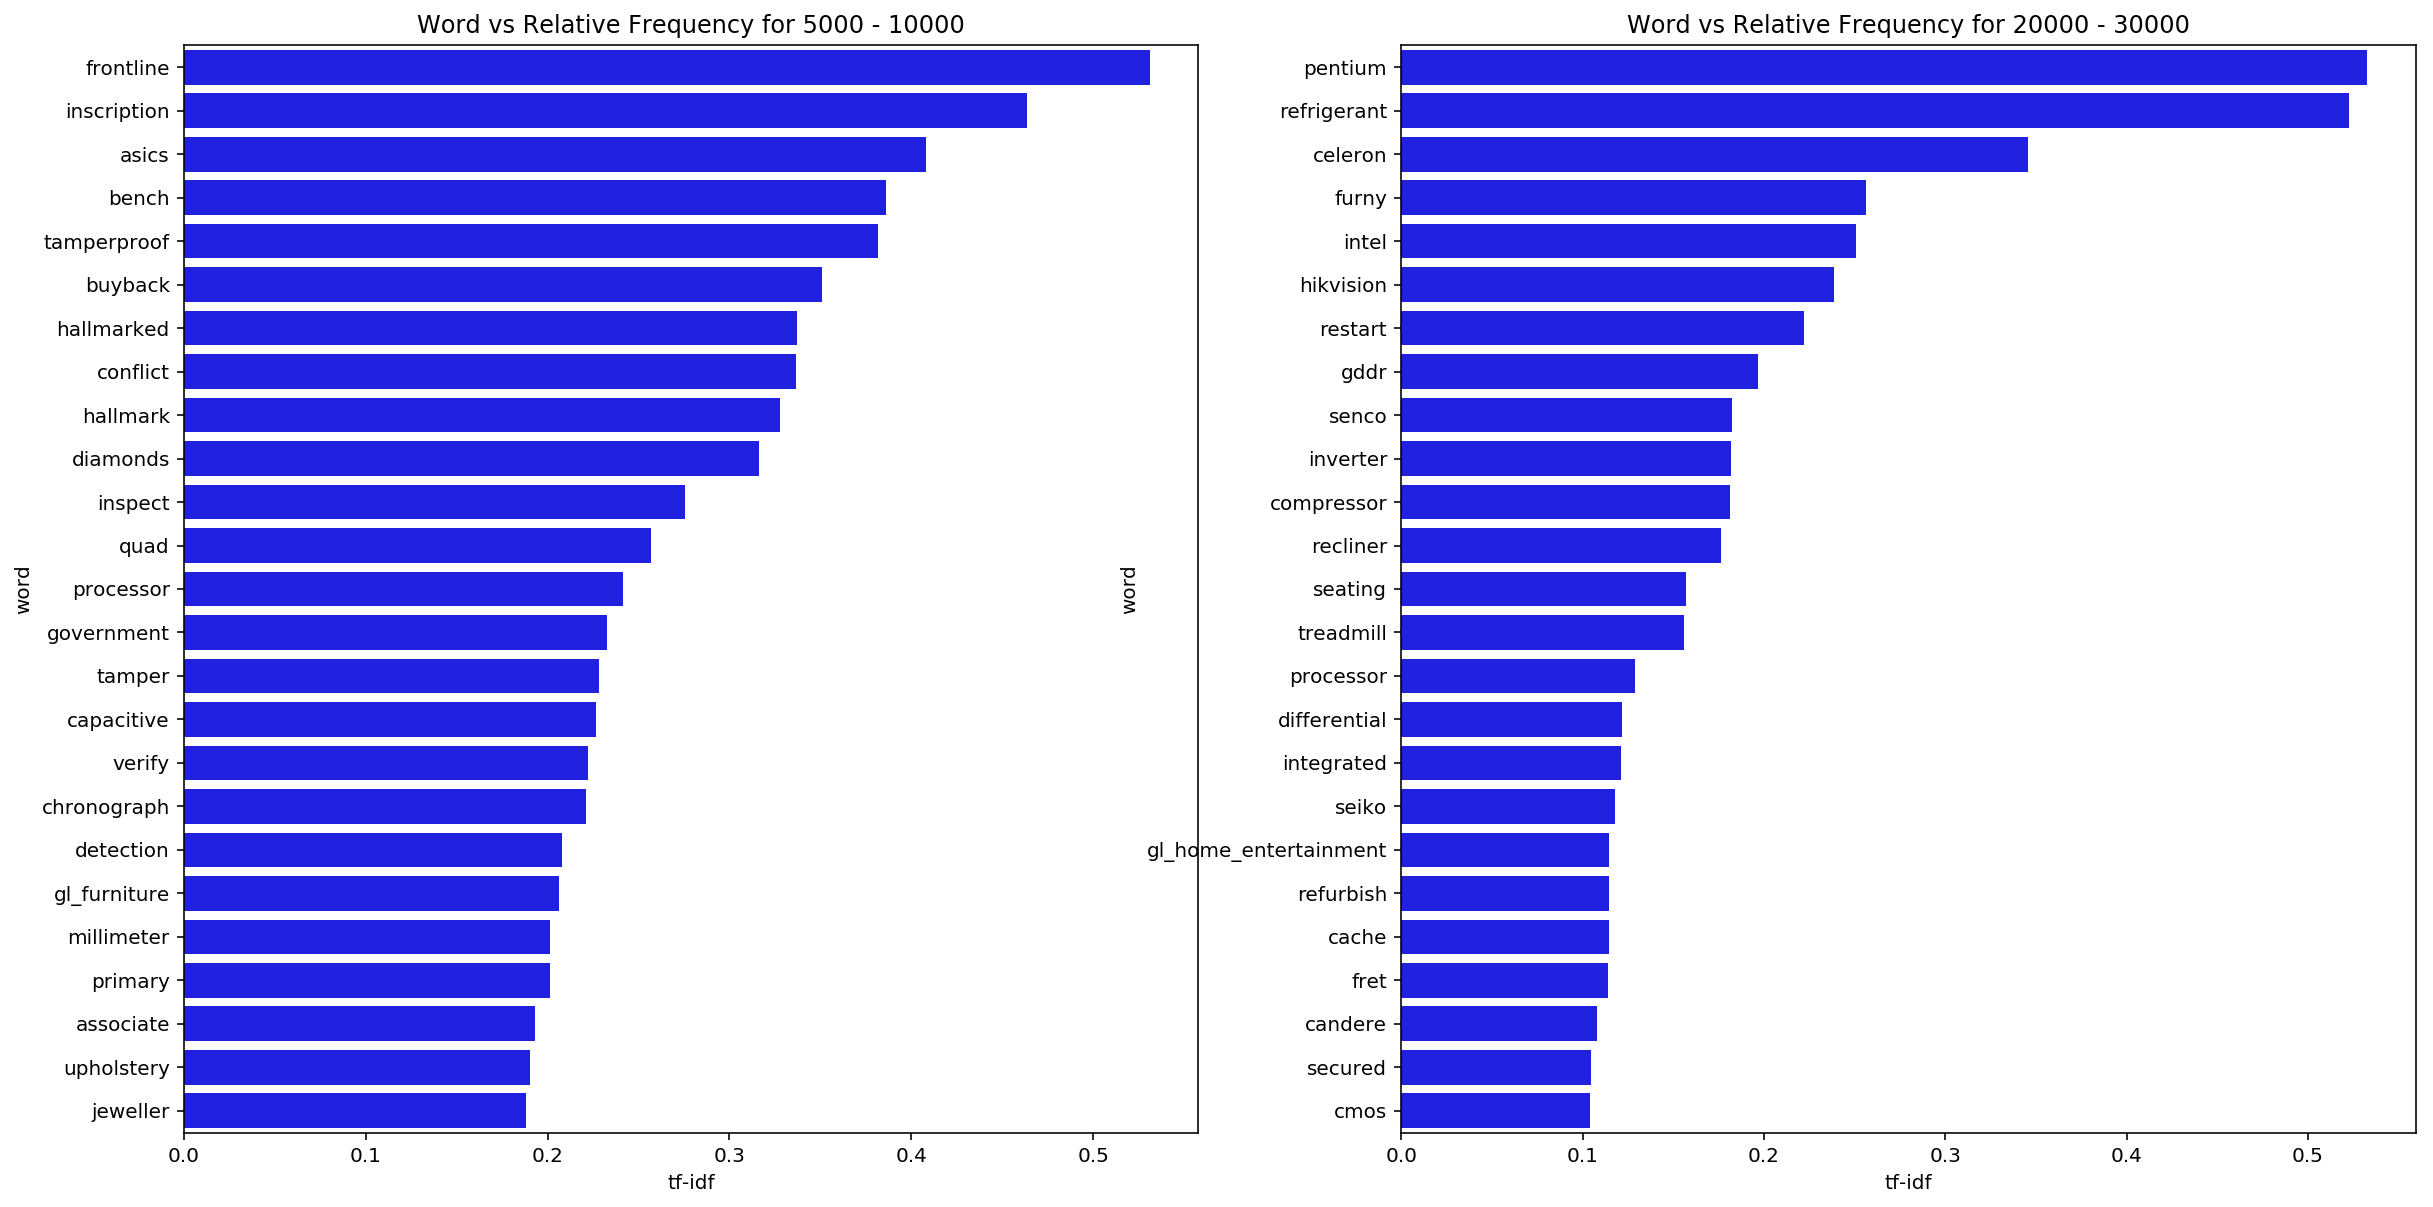

In [26]:
visualize_words_in_price_range(df_train,(5000,10000),(20000,30000),25)


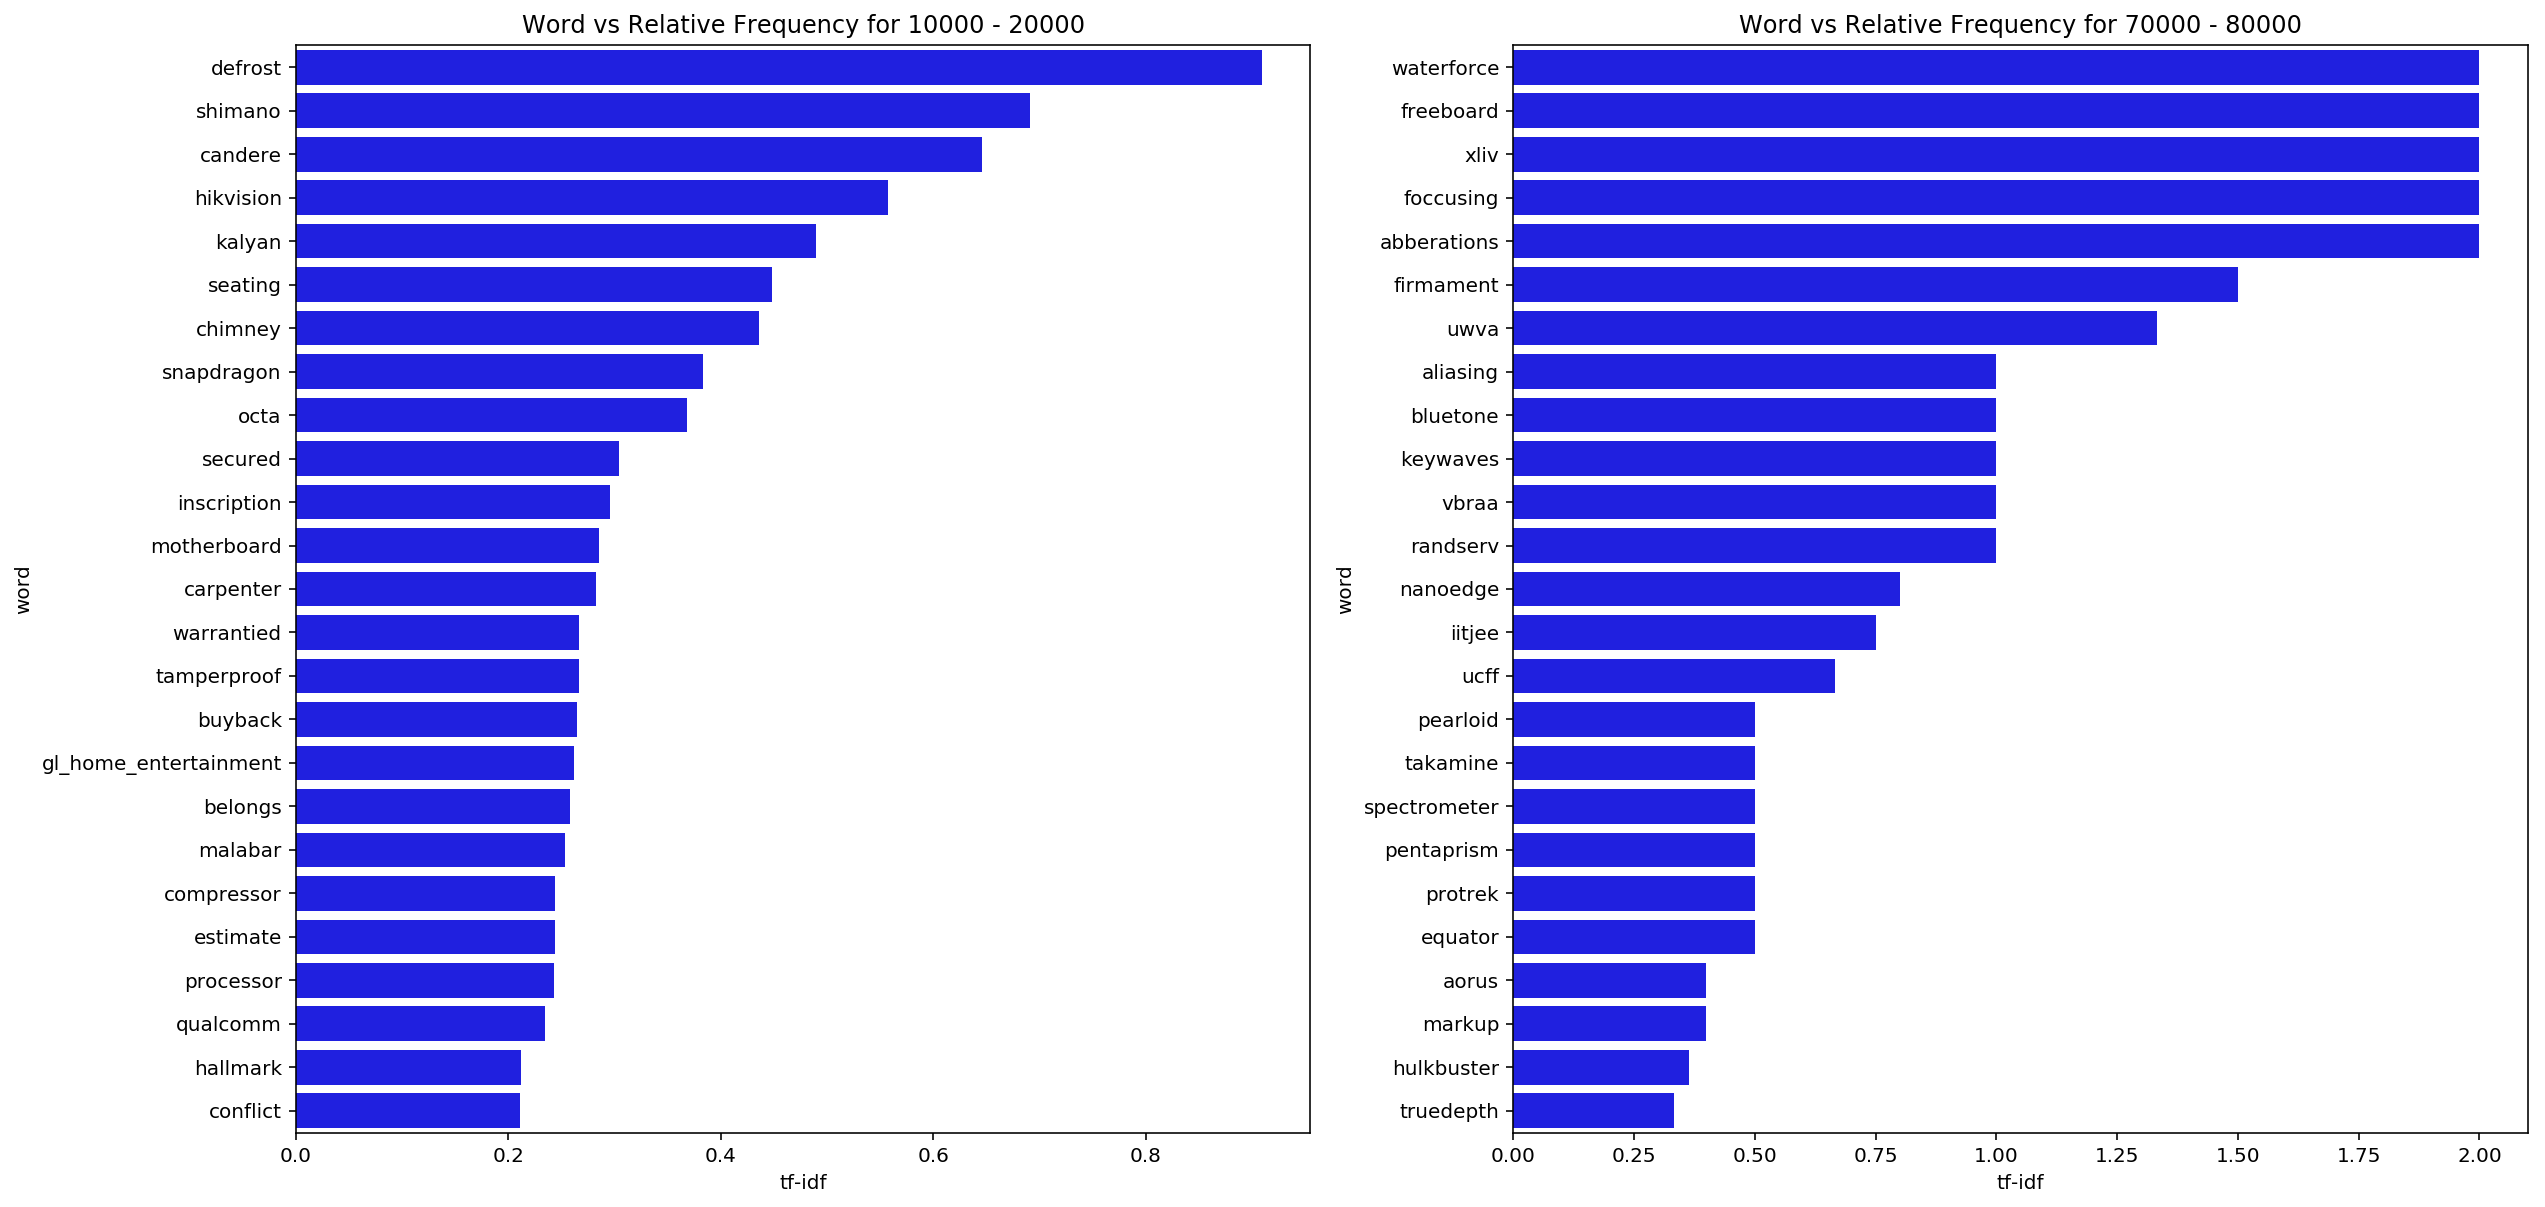

In [27]:
visualize_words_in_price_range(df_train,(10000,20000),(70000,80000),25)

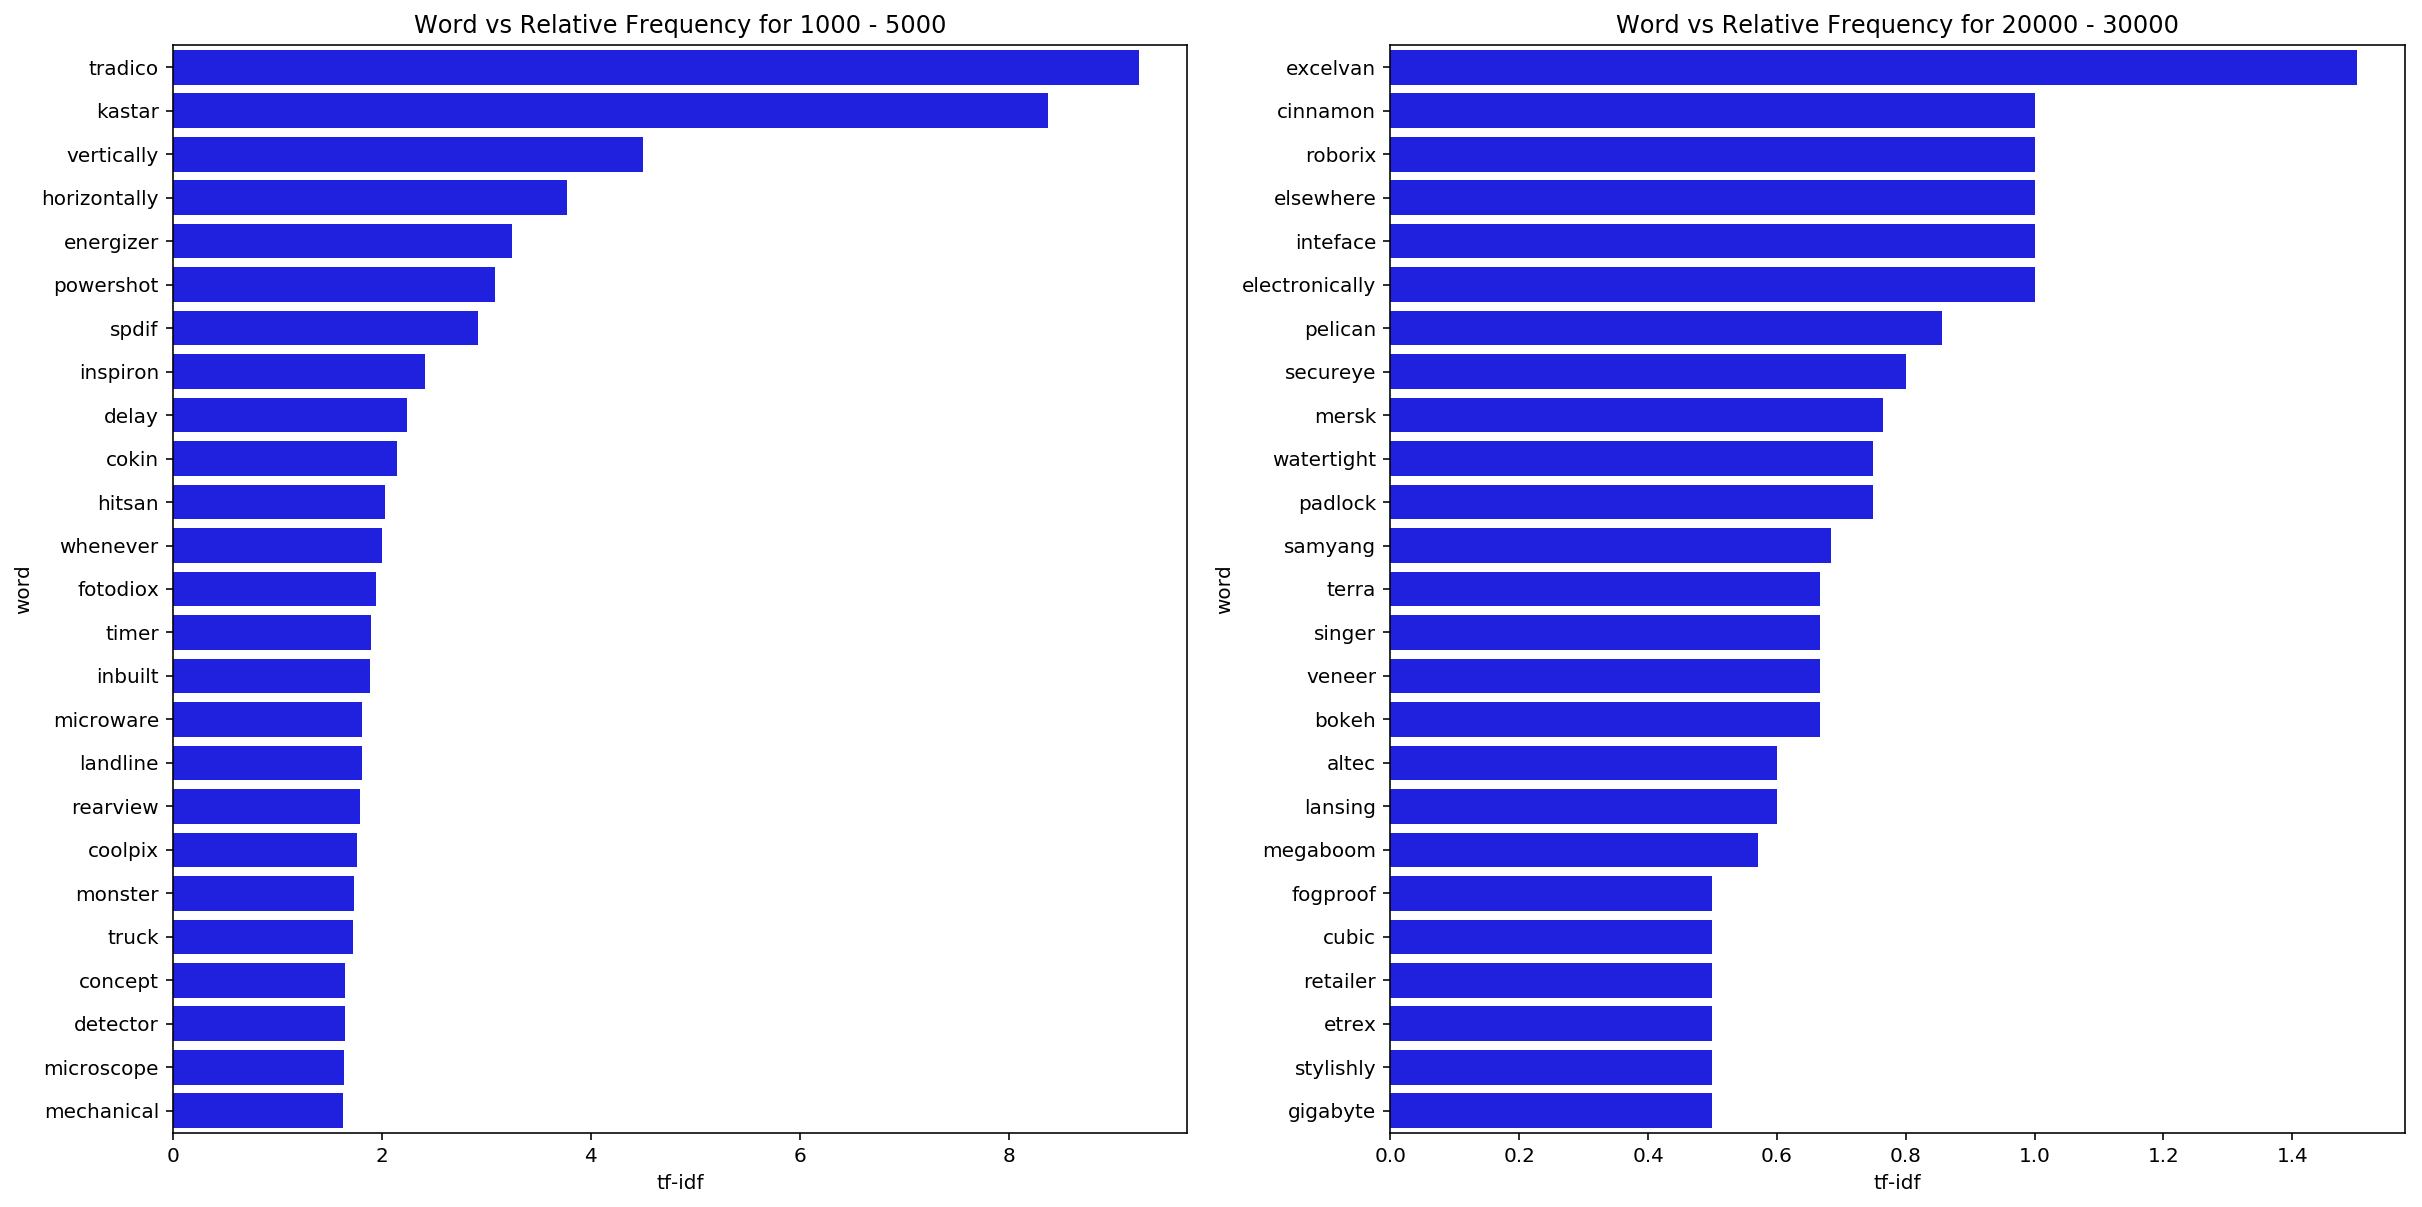

In [41]:
visualize_words_in_price_range(df_train[df_train.GL=='gl_electronics'],(1000,5000),(20000,30000),25)

### Visualize Average Price of a Word

In [89]:
word_price_dict = dict()
for word_array,price in df_train[['text',"PRICE"]].values:
    for word in word_array:
        if word in word_price_dict:
            word_price_dict[word]["price"].append(price)
            word_price_dict[word]["count"] += 1
        else:
            word_price_dict[word] = {"price":[price],"count":1}
            
word_price_dict = [(k,np.mean(v["price"]),v['count'],[le['wd'][k]]) for k,v in word_price_dict.items() if v["count"]>100 and len(k)>3 and k in le['wd']]
word_price_dict = pd.DataFrame(word_price_dict,columns=["word","avg_price","count","encoding"]).sort_values(["avg_price"])


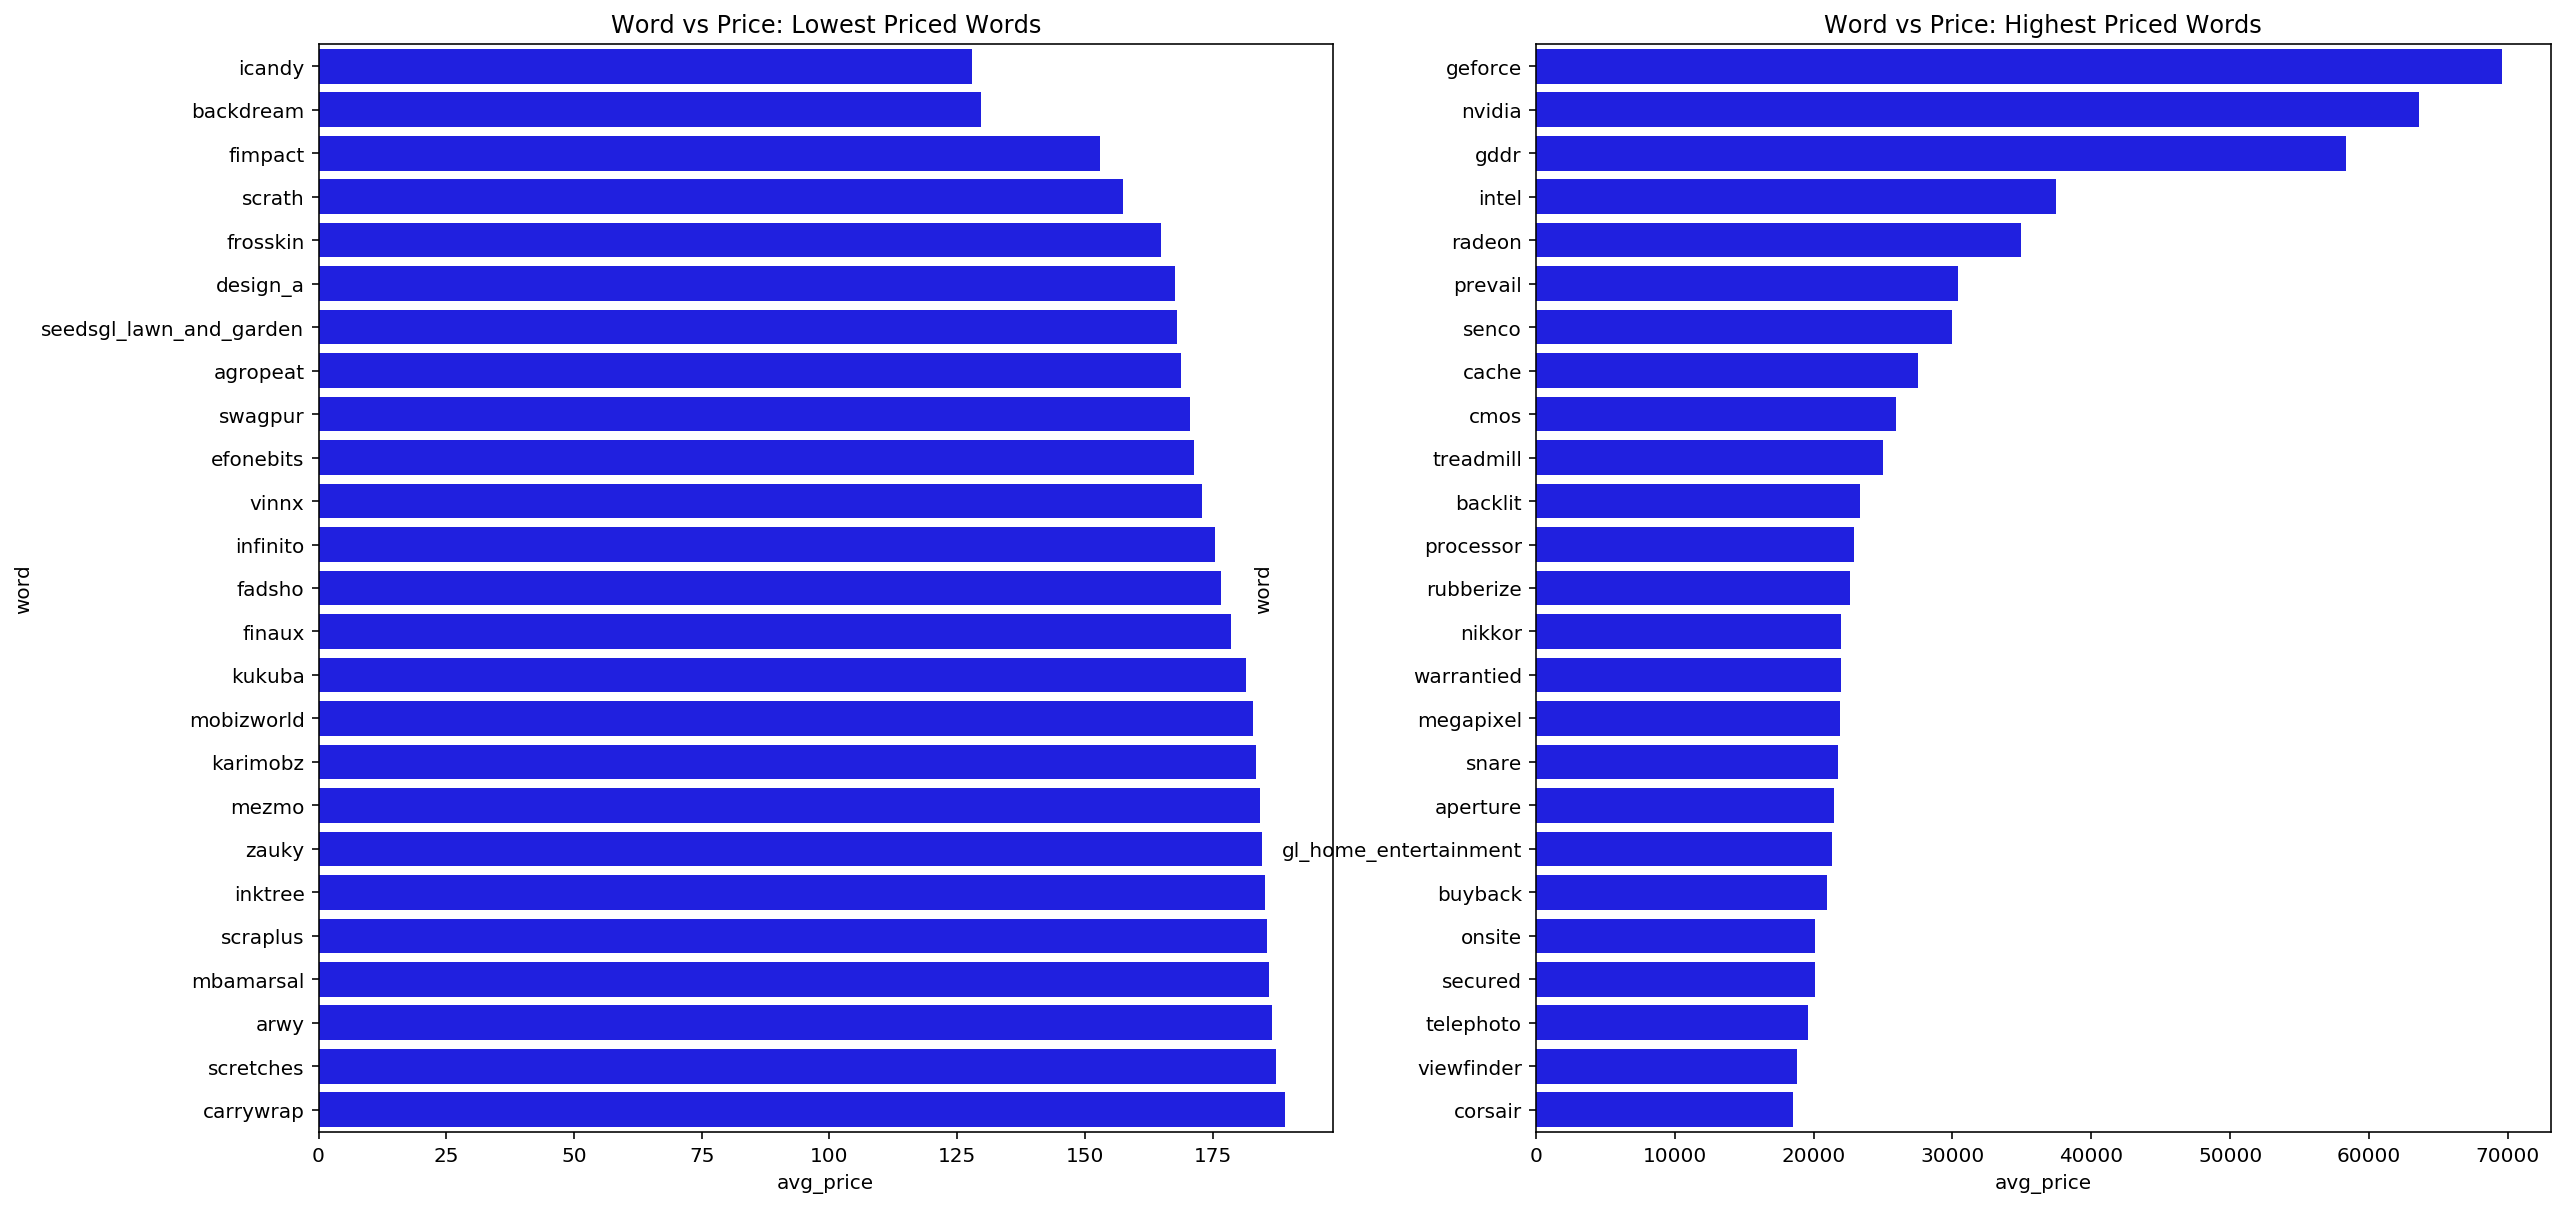

In [75]:
fig = plt.figure(figsize=(20,10));
ax = fig.add_subplot(1, 2, 1)
ax.set_title("Word vs Price: Lowest Priced Words")
sns.barplot(x="avg_price", y="word", data=word_price_dict.head(25), color="b", ax = ax);

ax = fig.add_subplot(1, 2, 2)
ax.set_title("Word vs Price: Highest Priced Words")
sns.barplot(x="avg_price", y="word", data=word_price_dict.tail(25)[::-1], color="b", ax = ax);
    


## Target Variable Distribution

- Log Transform of Target variable may help.

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


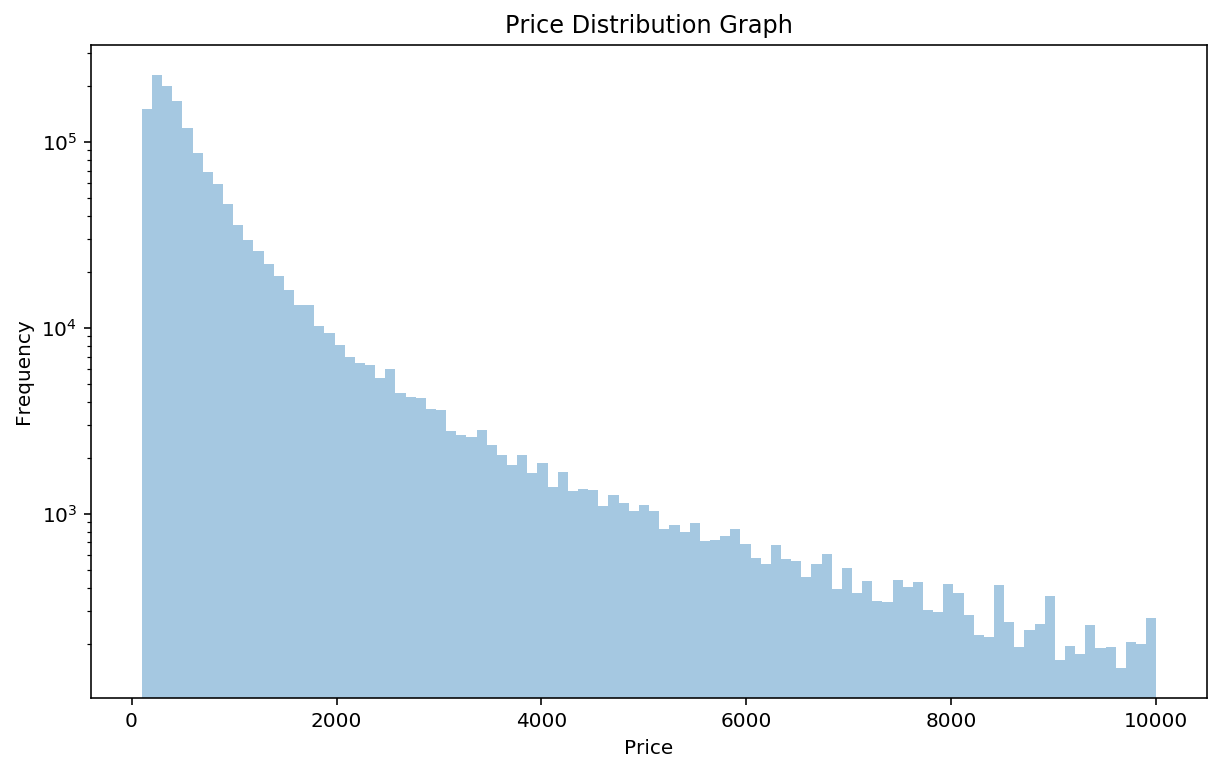

In [47]:
_ = plt.figure(figsize=(10,6));
_ = sns.distplot(df_train[df_train['PRICE']<1e4]['PRICE'].astype(float).values,bins=100,kde=False);
_ = plt.xlabel("Price");
_ = plt.ylabel("Frequency");
_ = plt.title("Price Distribution Graph");
_ = plt.semilogy();
_ = plt.show();

## Is GL useful?

Notice how average price by GLs is so different, hence `mean price` by GL will do better than normal mean price

In [24]:
print("Unique GLs in train set: ", df_train.GL.nunique())
print("Unique GLs in test set: ",df_test.GL.nunique())
print("GL present in test set, not in train set: ",set(df_test.GL.unique()) - set(df_train.GL.unique()))



Unique GLs in train set:  61
Unique GLs in test set:  56
GL present in test set, not in train set:  {'gl_digital_products_3_accessory', 'gl_bill_payments', 'gl_kindle_unlimited'}


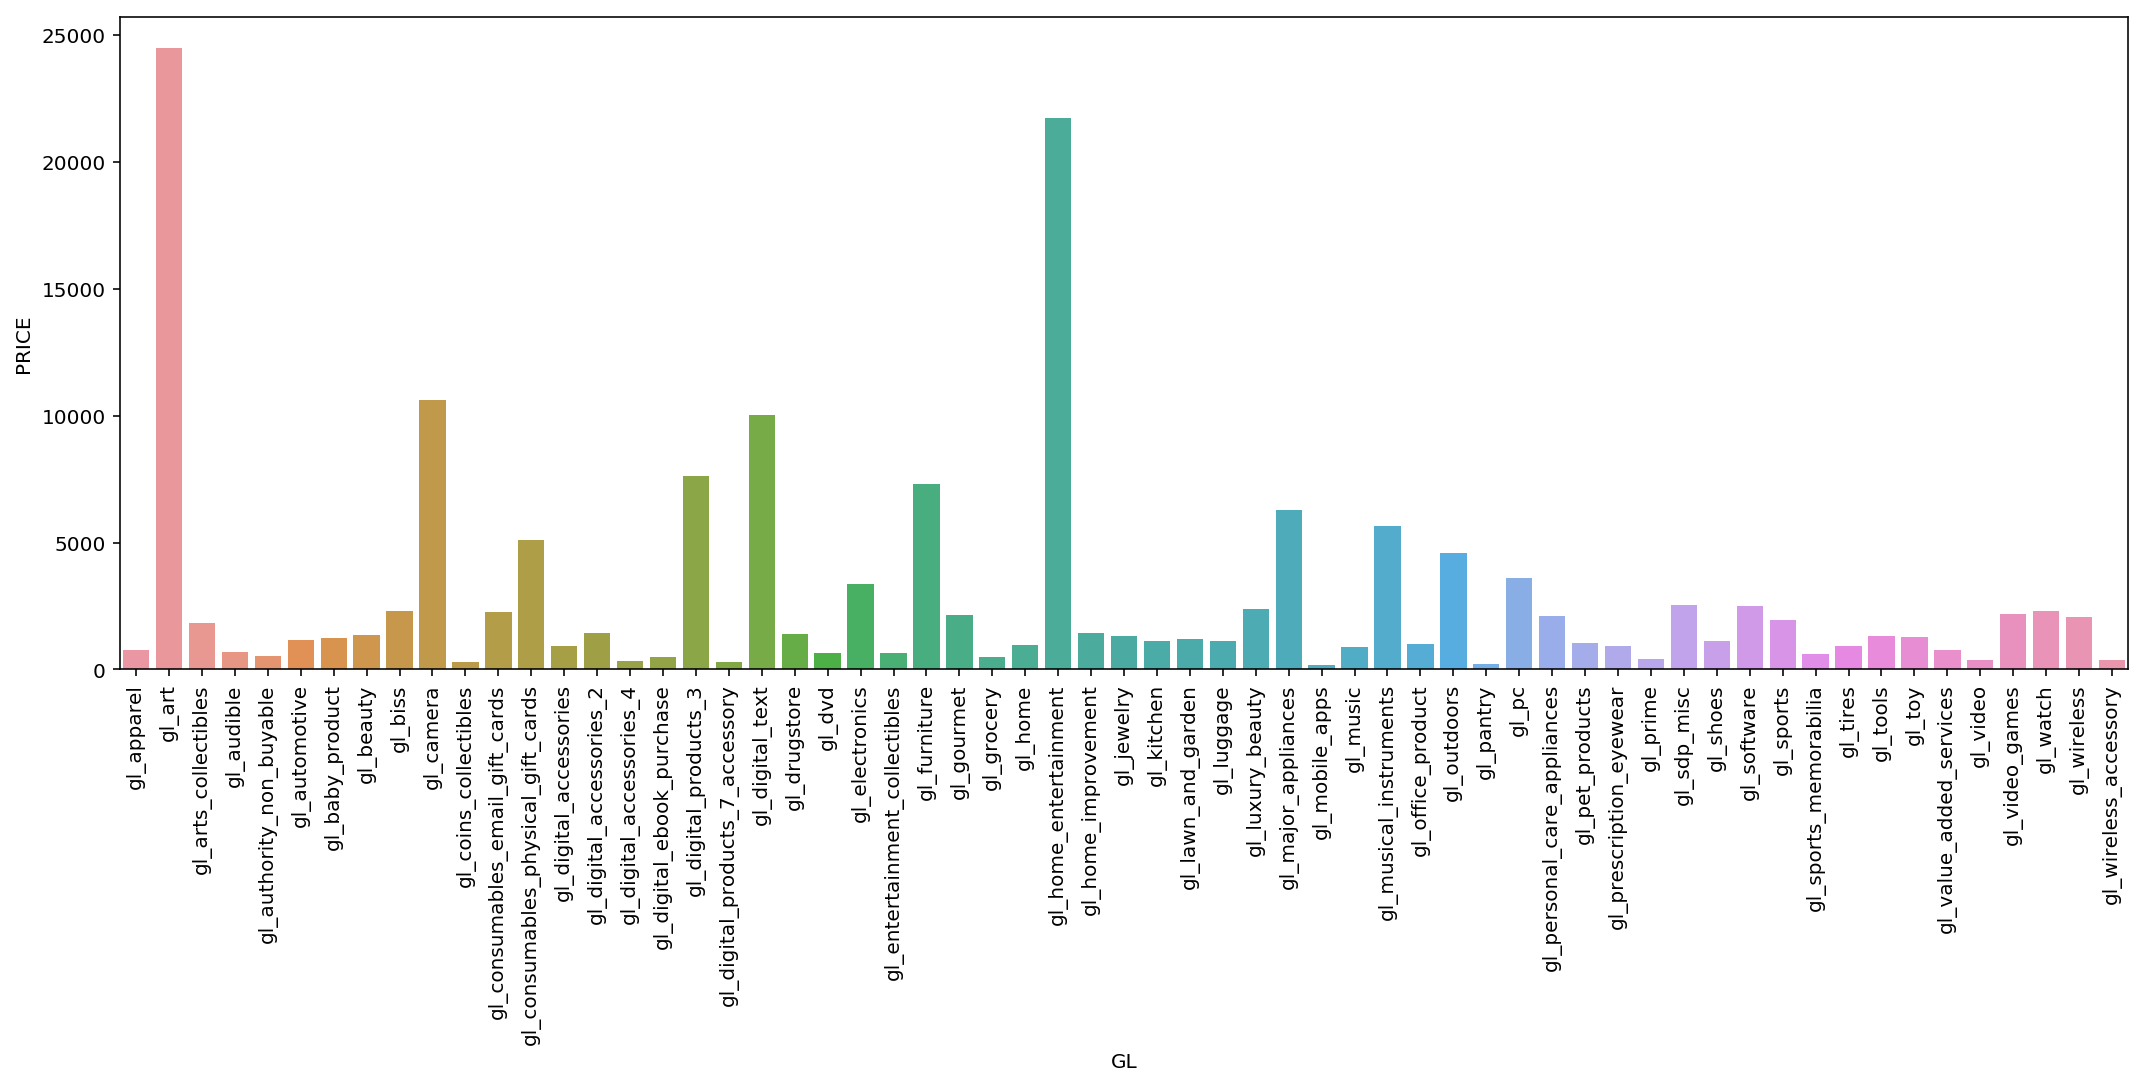

In [13]:
df_gl_means = df_train.groupby(["GL"])[['PRICE']].mean().reset_index()
df_results = df_test.merge(df_gl_means, on=["GL"],how="left")
df_results = df_results[["ID","PRICE"]]
df_results["PRICE"] = df_results["PRICE"].fillna(df_results["PRICE"].mean())
df_results.head()
df_results.to_csv("baseline.csv",index=False)

# Plot GL level pricing

_ = plt.figure(figsize=(18,6));
_ = sns.barplot(x="GL",y="PRICE",data=df_gl_means)
_ = plt.xticks(rotation=90);
_ = plt.show();


# Baselining

In [5]:
def show_results(y_test,y_validation):
    mse = mean_squared_error(y_test,y_validation)
    mape = mean_absolute_percentage_error(y_test,y_validation)
    medape = median_absolute_percentage_error(y_test,y_validation)
    print("MSE = %.2f, MAPE = %.2f, MEDAPE = %.2f"%(mse,mape, medape))
    return (mse,mape, medape)

## GL Based baseline

In [6]:
df_train_split_1,df_train_split_2 = train_test_split(df_train, test_size=0.2, random_state=42)
df_train_split_2.rename(columns={"PRICE":"ACTUAL_PRICE"},inplace=True)

df_gl_means = df_train_split_1.groupby(["GL"])[['PRICE']].mean().reset_index()
df_results = df_train_split_2.merge(df_gl_means, on=["GL"],how="left")
df_results = df_results[["ACTUAL_PRICE","PRICE"]]
df_results["PRICE"] = df_results["PRICE"].fillna(df_results["PRICE"].mean())

show_results(df_results["ACTUAL_PRICE"],df_results["PRICE"]);


MSE = 18781709.48, MAPE = 185.62, MEDAPE = 79.81


## Fasttext commandline based baseline

[Reference](https://fasttext.cc/docs/en/supervised-tutorial.html)

[Options](https://fasttext.cc/docs/en/options.html)

In [ ]:
!wget https://github.com/facebookresearch/fastText/archive/v0.2.0.zip > /dev/null
!unzip v0.2.0.zip > /dev/null
!cd fastText-0.2.0 && make -j16 > /dev/null

In [31]:
df_train_ft = preprocess_for_fasttext_cmd(df_train.copy(),jobs=32)
df_test_ft = preprocess_for_fasttext_cmd(df_test.copy(),jobs=32)

df_train_ft['RPRICE'] = np.ceil(np.cbrt(df_train['PRICE']))
df_train_ft['label'] = '__label__'
df_train_ft['label'] = df_train_ft['label'] + df_train_ft['RPRICE'].astype(str)

df_train_ft['text'] = df_train_ft['label']
df_train_ft['text'] = df_train_ft['text'] + " "
df_train_ft['text'] = df_train_ft['text'] + df_train_ft['char']

df_test_ft['text'] = df_test_ft['char']
train,test = train_test_split(df_train_ft[['text','PRICE']],test_size=0.2, random_state=42)
train[['text']].to_csv("fastText-0.2.0/train-1.txt",header=False,index=False)
test[['text']].to_csv("fastText-0.2.0/train-2.txt",header=False,index=False)

df_train_ft[['text']].to_csv("fastText-0.2.0/train.txt",header=False,index=False)
df_test_ft[['text']].to_csv("fastText-0.2.0/test.txt",header=False,index=False)

!head -n2 fastText-0.2.0/train.txt


__label__8.0 livsmart resin jewellery display stand  17x11cm  black[holds rings and other small items especially non hanging items each hand is specially designed to hang ring  bracelet or necklace beautiful gesture jewelry organizer ideal for retail shop counter display and personal use  helps you to organize rings]gl_jewelry
__label__8.0 quantum creation  does the supernatural lurk in the fourth dimension  gl_digital_ebook_purchase


In [57]:
df_train_ft[df_train_ft['RPRICE']>=80][["text","PRICE"]].sample(5)

,text,PRICE
843241,__label__83.0 apple iphone 7 plus rose gold ...,564419.640
1120071,__label__80.0 angel instrument fiber laser mar...,499000.000
1183035,__label__95.0 shree divyaratna 17 7 carat natu...,831600.000
358827,__label__84.0 pny quadro m6000 24 gb pci e gra...,582626.275
1395535,__label__84.0 ambience arts royal maharaja kin...,592372.880


In [63]:
!cd fastText-0.2.0 && ./fasttext supervised -input train-1.txt -output price_prediction -lr 0.2 -epoch 10
print("-"*80)
!cd fastText-0.2.0 && ./fasttext test price_prediction.bin train-2.txt
print("-"*80)
!cd fastText-0.2.0 && ./fasttext test price_prediction.bin train-2.txt 5
!cd fastText-0.2.0 && ./fasttext predict price_prediction.bin train-2.txt > validation.txt
!cd fastText-0.2.0 && ./fasttext predict price_prediction.bin test.txt > prediction.txt

Read 67M words
Number of words:  874961
Number of labels: 89
Progress: 100.0% words/sec/thread: 1298648 lr:  0.000000 loss:  1.676980 ETA:   0h 0m ETA:   0h 0mh 0m 1.725391 ETA:   0h 0m
--------------------------------------------------------------------------------
N	289921
P@1	0.392
R@1	0.392
--------------------------------------------------------------------------------
N	289921
P@5	0.175
R@5	0.877


In [33]:
df_verify = pd.read_csv("fastText-0.2.0/validation.txt",header=None)
df_verify.columns=["result"]
df_verify['values'] = df_verify['result'].apply(lambda x:x[9:]).astype(float)
df_verify['values'] = np.power(df_verify['values'],3)

show_results(test['PRICE'],df_verify['values'].values);




MSE = 15540952.59, MAPE = 58.46, MEDAPE = 33.89


In [ ]:
df_results = pd.read_csv("fastText-0.2.0/prediction.txt",header=None)

df_results.shape
df_results.columns=["result"]
df_results.head()

df_results['values'] = df_results['result'].apply(lambda x:x[9:]).astype(float)
df_results['values'] = np.power(df_results['values'],3)
df_results.head()

df_sub = df_test[['ID']]
df_sub['PRICE'] = df_results['values']
df_sub.to_csv("fasttext-cubic.csv",index=False)


# Modelling

- We use embedding dimension of 50 through-out

## Intro to 1D CNNs and Word Embeddings

**The Analogues**
- 1 image = 1 Asin Full Text
- Image Channels = Embedding Dimensions
- Images are 2D (depth is 3 channels), Text is 1D sequence (depth is 50 embedding dimensions)
- Edges/Gradients/Patterns in images = Text Phrases and important multi-word sequences

**Understanding the structure of each row**

Initially we have : Words -> Full text

Finally after embedding we get : Each word as a list of 50 numbers, Text as list of Words. 

Single row shape is `(1,50,#Words)`

Full Data shape is `(#Num examples, 50, #Word_Per_Row)`

**Multiple Receptive Fields and Residual connections**

Here

In [7]:
def mape_error(y_true, y_pred):
    diff = K.abs((y_true - y_pred) / K.clip(K.abs(y_true),
                                            K.epsilon(),
                                            None))
    return 100. * K.mean(diff)


## Winning Model: Using Words and Embedding Layer

In [58]:
# set parameters:
max_features = 50000
maxlen = 100
batch_size = 512
embedding_dims = 50
pretrained_dims = 50
filters = 256
kernel_size = 3
hidden_dims = 256

train,validation = train_test_split(df_train, test_size=0.2, random_state=42)
x_train,x_train_pt,x_gl_train,y_train = train['text_encoded'].values,train['glove_encoded'].values,train['GL_encoded'].values,train['PRICE'].values
x_test,x_test_pt,x_gl_test,y_test = validation['text_encoded'].values,validation['glove_encoded'].values,validation['GL_encoded'].values,validation['PRICE'].values

train_gl_stats = train.groupby(["GL"])["PRICE"].agg(['mean','std','min','max']).reset_index()
validation_gl_stats = validation[["GL"]].merge(train_gl_stats,on="GL",how="left")
validation_gl_stats = validation_gl_stats.fillna(validation_gl_stats.mean())

train_gl_stats = train[["GL"]].merge(train_gl_stats,on="GL",how="left")
train_gl_stats = train_gl_stats[['mean','min','max']].values
validation_gl_stats = validation_gl_stats[['mean','min','max']].values

x_train = sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = sequence.pad_sequences(x_test, maxlen=maxlen)

x_train_pt = sequence.pad_sequences(x_train_pt, maxlen=maxlen)
x_test_pt = sequence.pad_sequences(x_test_pt, maxlen=maxlen)


In [288]:

main_input = Input(shape=(maxlen,), dtype='int32', name='Text_Encoding')
embedding = Embedding(max_features,
                    embedding_dims,
                    input_length=maxlen,
                    name="Text_Embedding")(main_input)
pretrained_embedding_input = Input(shape=(maxlen,pretrained_dims), dtype='float32', name='Pretrained_Embedding')

vlayer0 = concatenate([embedding,pretrained_embedding_input])

vlayer1 = conv_layer(vlayer0,n_kernels=64,kernel_size=3,padding='valid')
vlayer1 = MaxPooling1D()(vlayer1)

vlayer2 = conv_layer(vlayer1,n_kernels=64,kernel_size=3,padding='same')
vlayer4 = MaxPooling1D(padding='same')(vlayer2)
vlayer = conv_layer(vlayer4,n_kernels=25,kernel_size=3,padding='same')
vlayer6 = GlobalMaxPooling1D()(vlayer)

vlayer3 = conv_layer(vlayer2,n_kernels=32,kernel_size=5,padding='same')
vlayer3 = SpatialDropout1D(0.05)(vlayer3)

vlayer5 = concatenate([vlayer3,vlayer2])
vlayer_out = GlobalAveragePooling1D()(vlayer5)
vlayer_out = concatenate([vlayer_out,vlayer6])



x = SpatialDropout1D(0.05)(embedding)
x = Conv1D(filters,
                 kernel_size,
                 padding='valid',
                 activation='relu',
                 strides=1)(x)
x = SpatialDropout1D(0.05)(x)
# we use max pooling:

x = GlobalMaxPooling1D()(x)
auxiliary_input =  Input(shape=(1,), dtype='int32', name='GL_encoding')
aux = Embedding(len(gl_le.classes_),
                    8,
                    input_length=1,
                    name="GL_embedding")(auxiliary_input)
aux = Flatten()(aux)
aux = Dropout(0.05)(aux)

gl_stats_input =  Input(shape=(3,), dtype='float32', name='GL_stats')
gl_inputs = BatchNormalization()(gl_stats_input)
gl_inputs = Dropout(0.1)(gl_inputs)

gl_inputs = concatenate([gl_inputs,aux])
gl_inputs = Dense(8)(gl_inputs)

x = concatenate([vlayer_out,x,gl_inputs,vlayer6])

# We add a vanilla hidden layer:
x = Dense(hidden_dims)(x)
x = Dropout(0.1)(x)
x = Activation('relu')(x)

# We project onto a single unit output layer, and squash it with a sigmoid:
main_output = Dense(1)(x)

model = Model(inputs=[main_input, auxiliary_input, pretrained_embedding_input,gl_stats_input], outputs=[main_output])
visualizer = Model(inputs=[main_input, pretrained_embedding_input], outputs=vlayer)
embedder = Model(inputs=[main_input], outputs=embedding)

model.compile(loss=mape_error,
              optimizer='adam',
              metrics=['mean_squared_error',mape_error])

In [289]:
print("Param count = ", model.count_params())

model.fit([x_train,x_gl_train,x_train_pt,train_gl_stats], y_train,
          batch_size=batch_size,
          epochs=4,
          validation_data=([x_test,x_gl_test,x_test_pt,validation_gl_stats], y_test),
          shuffle=True)


Param count =  2692186
Train on 1159686 samples, validate on 289922 samples
Epoch 1/4
1159686/1159686 [==============================] - 183s 158us/step - loss: 39.1693 - mean_squared_error: 4036273585.7779 - mape_error: 39.1384 - val_loss: 36.0679 - val_mean_squared_error: 19304524.5799 - val_mape_error: 36.0305
Epoch 2/4
1159686/1159686 [==============================] - 174s 150us/step - loss: 34.0505 - mean_squared_error: 4035896384.1105 - mape_error: 34.0068 - val_loss: 34.4848 - val_mean_squared_error: 19010423.5580 - val_mape_error: 34.4358
Epoch 3/4
1159686/1159686 [==============================] - 174s 150us/step - loss: 32.0953 - mean_squared_error: 4035703541.2194 - mape_error: 32.0402 - val_loss: 34.3195 - val_mean_squared_error: 18958027.0048 - val_mape_error: 34.2595
Epoch 4/4
1159686/1159686 [==============================] - 174s 150us/step - loss: 30.6405 - mean_squared_error: 4035554802.1871 - mape_error: 30.5746 - val_loss: 33.2849 - val_mean_squared_error: 18880669

In [290]:
y_validation = model.predict([x_test,x_gl_test, x_test_pt,validation_gl_stats])
show_results(y_test,y_validation.reshape((-1)));



# ======== Using MSE as the Error Fn ==========
# MSE = 13719889.66, MAPE = 97.94, MEDAPE = 48.79
# MSE = 13799032.45, MAPE = 97.77, MEDAPE = 48.57

# ======= Using MAPE as the Error Fn ==========
# MSE = 18725153.39, MAPE = 33.20, MEDAPE = 24.86
# MSE = 18810649.30, MAPE = 33.22, MEDAPE = 25.05

MSE = 18880669.22, MAPE = 33.21, MEDAPE = 25.25


In [303]:
from keras.models import load_model
model.save('model.h5')
visualizer.save('visualizer.h5')
embedder.save('embedder.h5')


In [10]:
from keras.models import load_model
model = load_model('model.h5',custom_objects={'mape_error': mape_error})
visualizer = load_model('visualizer.h5',custom_objects={'mape_error': mape_error})
embedder = load_model('embedder.h5',custom_objects={'mape_error': mape_error})

## Other Models

- Model 2: Using Characters and Embedding Layer
    - Very Less Preprocessing needed since used set of characters is around 128.
    - Since the Sequence length is very long this is harder to tune though.

# Inspecting the Model

## Inspecting Embeddings

- Word Cloud and hue on price bucket (Select top 10 words from each bucket)
- 

In [114]:
word_embeddings = embedder.predict(sequence.pad_sequences(word_price_dict['encoding'].values, maxlen=maxlen,padding='post'))[:,:1,:].reshape((-1,50))

pca = PCA(n_components=2)
word_embeddings = pca.fit_transform(word_embeddings)
print(pca.explained_variance_ratio_)

word_price_dict['x'] = word_embeddings[:,0]
word_price_dict['y'] = word_embeddings[:,1]

def get_bucketer(buckets):
    def price_buckets(price):
        for i,bucket in enumerate(buckets[:-1]):
            if price>=bucket and price<buckets[i+1]:
                return "%s - %s"%(bucket,buckets[i+1])
        return "Above %s"%(buckets[-1])
    return price_buckets


word_price_dict['price_bucket'] = word_price_dict['avg_price'].apply(get_bucketer([0,1000,3000,5000,10000,20000,50000]))


[0.36184075 0.11355552]


<Figure size 1152x1152 with 0 Axes>

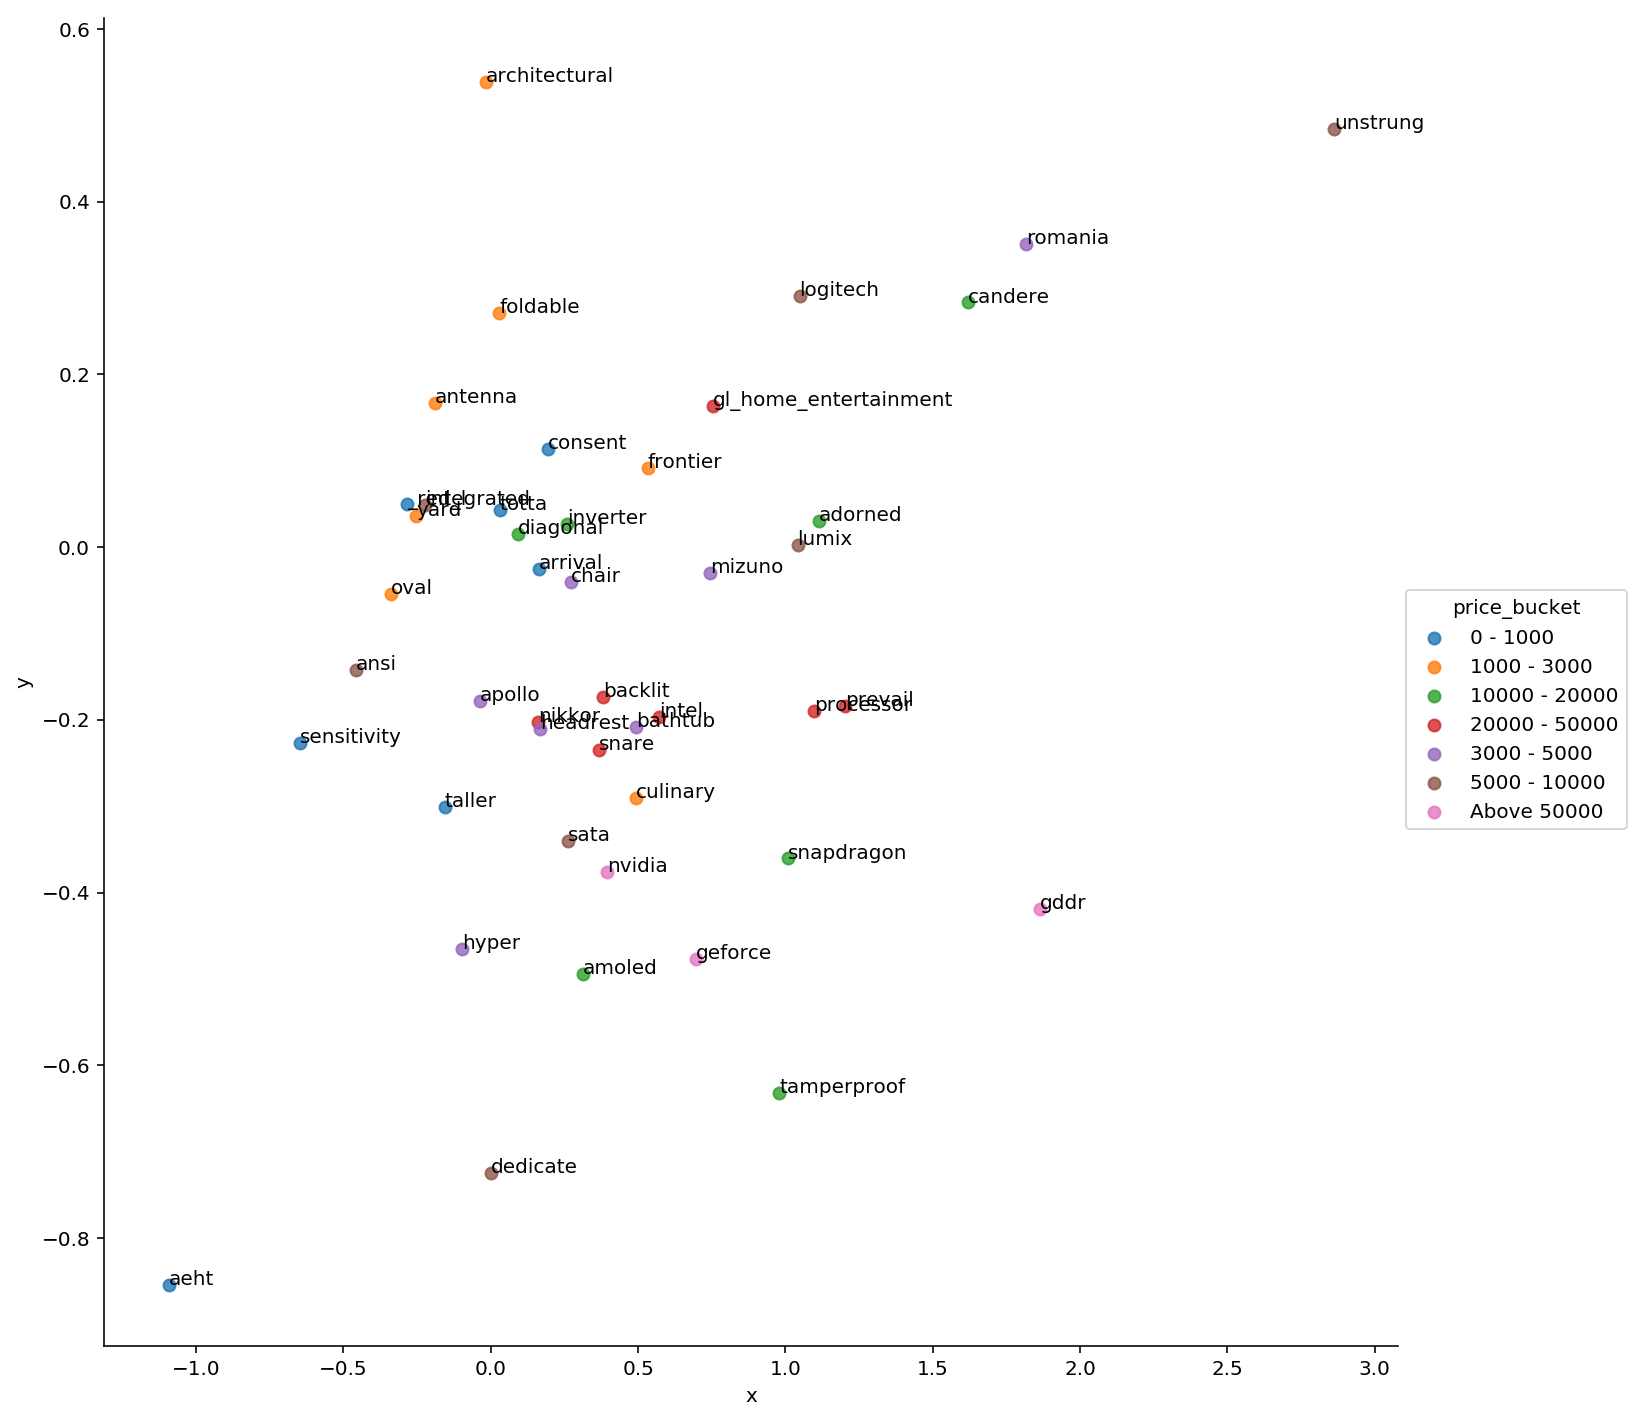

In [310]:
_ = plt.figure(figsize=(16,16));
plot_df = word_price_dict.groupby('price_bucket', group_keys=False).apply(lambda x: x.sample(min(len(x), 7)))
x = plot_df['x'].values
y = plot_df['y'].values

_ = sns.lmplot(x='x',y='y',data=plot_df,hue='price_bucket', fit_reg=False, size=10);
ax = plt.gca();

for i, txt in enumerate(plot_df['word'].values):
    _ = ax.annotate(txt, (x[i], y[i]));
_ = plt.show();

## Model Image representation

<module 'keras.utils.vis_utils' from '/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/utils/vis_utils.py'>

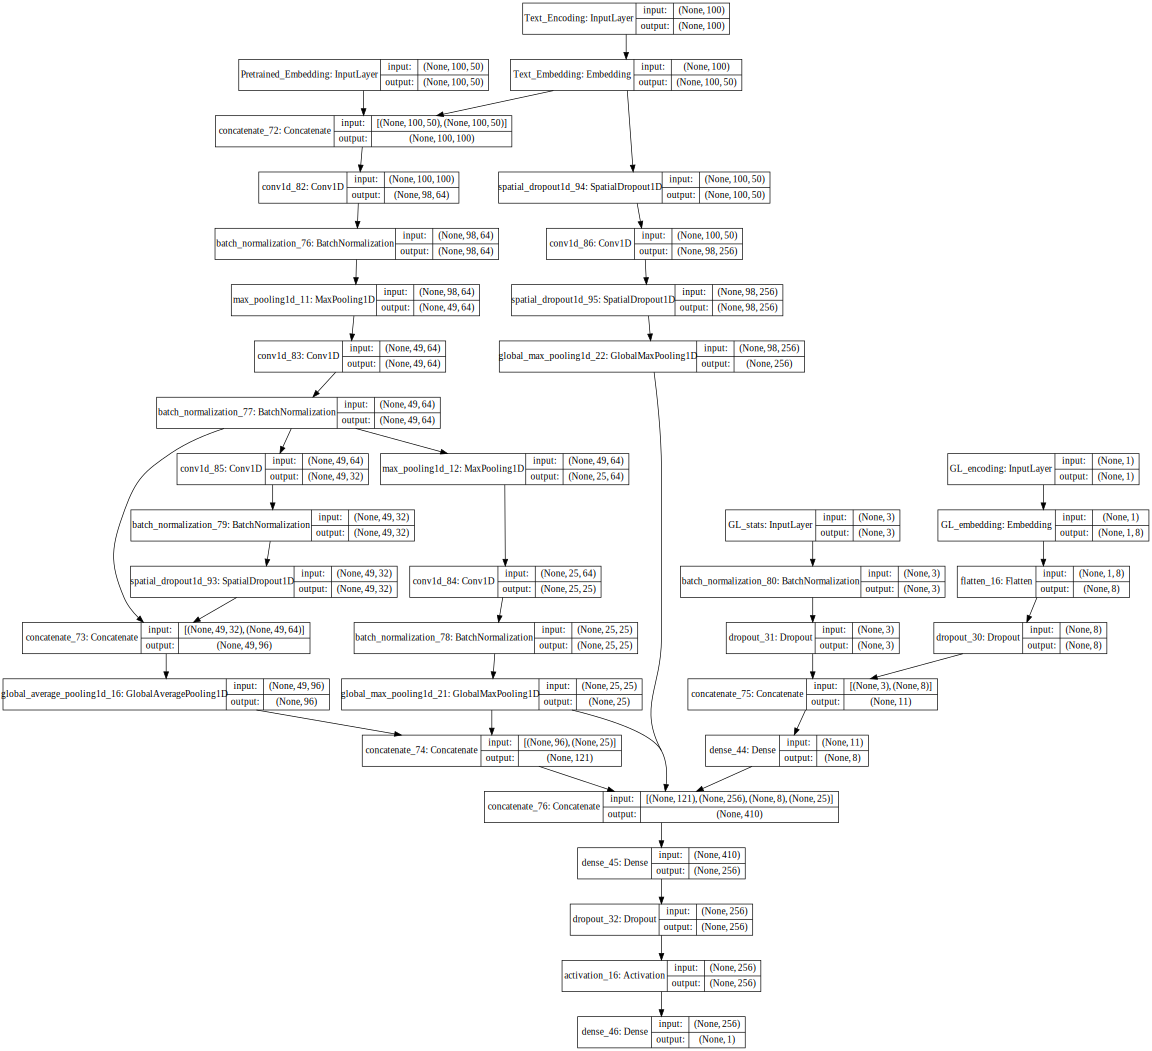

In [291]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
reload(keras.utils.vis_utils)
m2d = model_to_dot(model, show_shapes=True,)
m2d.set_size('16x24')
SVG(m2d.create(prog='dot', format='svg'))

In [292]:
from keras.utils import plot_model
plot_model(model, to_file='model.png')

## How Do Costly vs Cheaper Asins Look in Images


In [300]:
def visualize_filter_price_range(lower,upper,num_examples=5,cmap=None):
    image_size_multiplier = 4
    rows = 2
    columns = num_examples
    fig_height = rows * image_size_multiplier * 2
    fig_width = num_examples * image_size_multiplier

    fig = plt.figure(figsize=(fig_width, fig_height))
    plt.subplots_adjust(bottom=0.1, top=0.8)
    
    idx = np.where((y_train >= lower[0]) & (y_train <= lower[1]))[0]
    idx = sample(list(idx), num_examples)
    
    imgs = []
    preds = []
    actuals = []
    vmin, vmax = None,None
    for i in idx:
        pred = model.predict([x_train[i:i+1],x_gl_train[i:i+1], x_train_pt[i:i+1],train_gl_stats[i:i+1]])
        img = visualizer.predict([x_train[i:i+1],x_train_pt[i:i+1]])
        img = img.reshape((img.shape[1],img.shape[2]))
        imgs.append(img)
        preds.append(pred)
        actuals.append(y_train[i])
     
    idx = np.where((y_train >= upper[0]) & (y_train <= upper[1]))[0]
    idx = sample(list(idx), num_examples)
        
    for i in idx:
        pred = model.predict([x_train[i:i+1],x_gl_train[i:i+1], x_train_pt[i:i+1],train_gl_stats[i:i+1]])
        img = visualizer.predict([x_train[i:i+1],x_train_pt[i:i+1]])
        img = img.reshape((img.shape[1],img.shape[2]))
        imgs.append(img)
        preds.append(pred)
        actuals.append(y_train[i])
        
    imgs = np.array(imgs)
    vmin,vmax = np.min(imgs),np.max(vmax)
    jdx = 1
    for i,pred in enumerate(preds):
        ax = fig.add_subplot(rows * 2, columns, jdx, xticks=[], yticks=[])
        ax.imshow(imgs[i], cmap=cmap,vmin=vmin,vmax=vmax)
        ax.set_title("Actual = %.0f, Predicted = %.0f"%(actuals[i],pred))
        jdx += 1
        

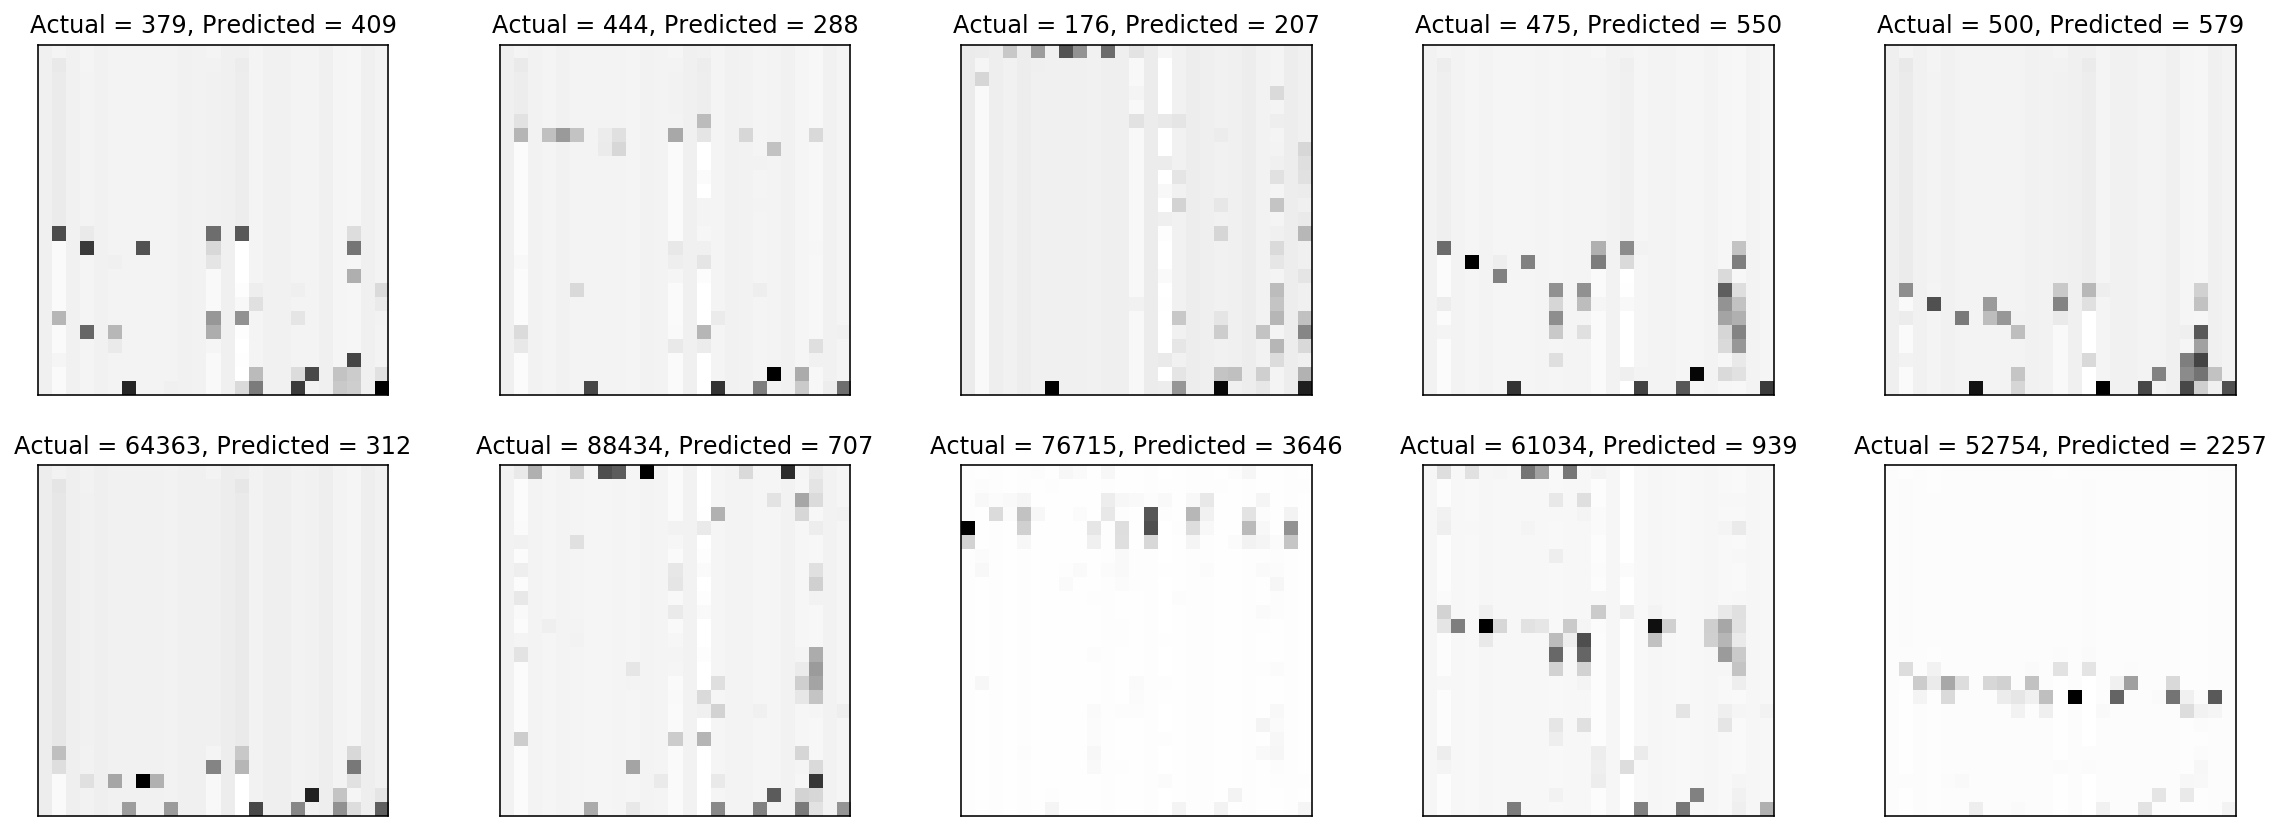

In [301]:
visualize_filter_price_range([100,500],[50000,100000],cmap='Greys')

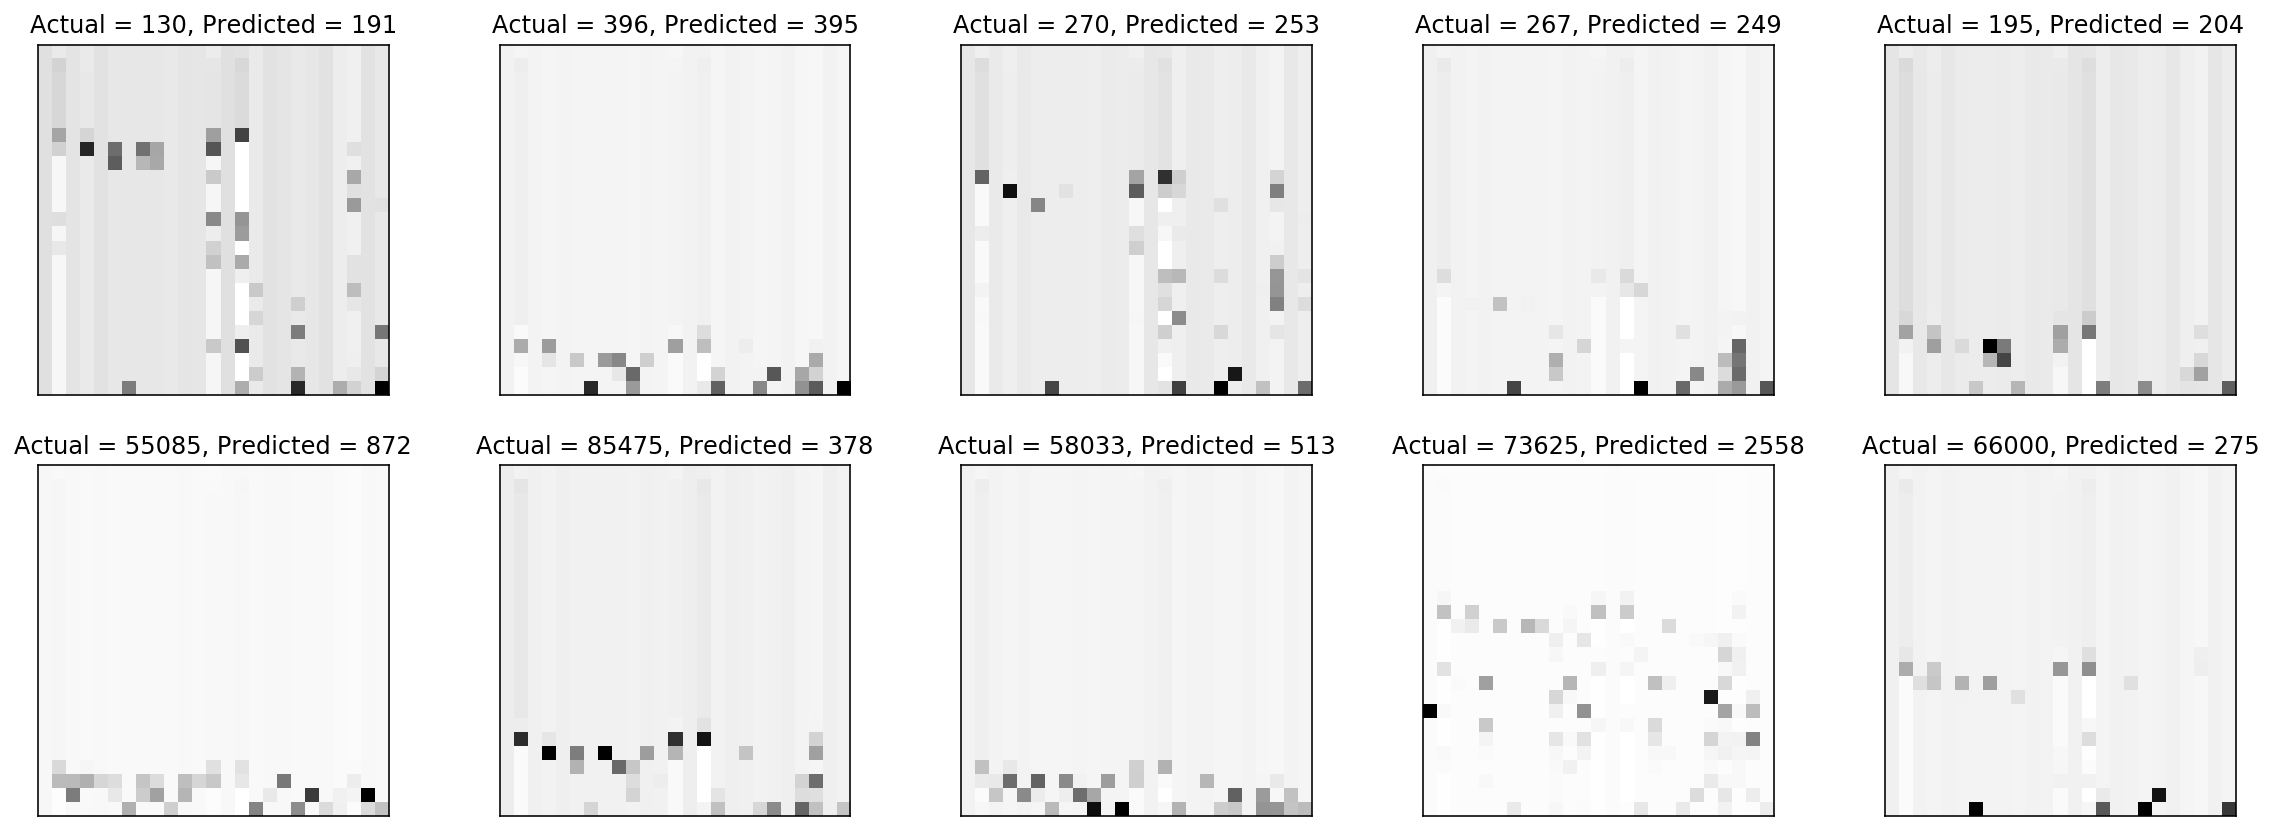

In [302]:
visualize_filter_price_range([100,500],[50000,100000],cmap='Greys')

## Error Inspection
- Error Distribution
- Actual Price vs Predicted Price Plot

[Reference](https://www.qualtrics.com/support/stats-iq/analyses/regression-guides/interpreting-residual-plots-improve-regression/)

In [203]:
df_preds = pd.DataFrame({"actual":y_test,"prediction":y_validation.reshape((-1)),
                         "TITLE":df_train_split_2["TITLE"],"BULLET_POINTS":df_train_split_2["BULLET_POINTS"],"GL":df_train_split_2["GL"]})
df_preds['ape'] = 100*np.abs(df_preds['actual'] - df_preds['prediction'])/np.clip(np.abs(df_preds['actual']),1e-3,None)
df_preds['error'] = df_preds['prediction'] - df_preds['actual']



In [246]:
df_preds['error'].describe()

count    289922.000000
mean       -520.006871
std        4295.906179
min     -974357.248613
25%        -264.789635
50%         -51.106886
75%          24.995694
max        4153.449866
Name: error, dtype: float64

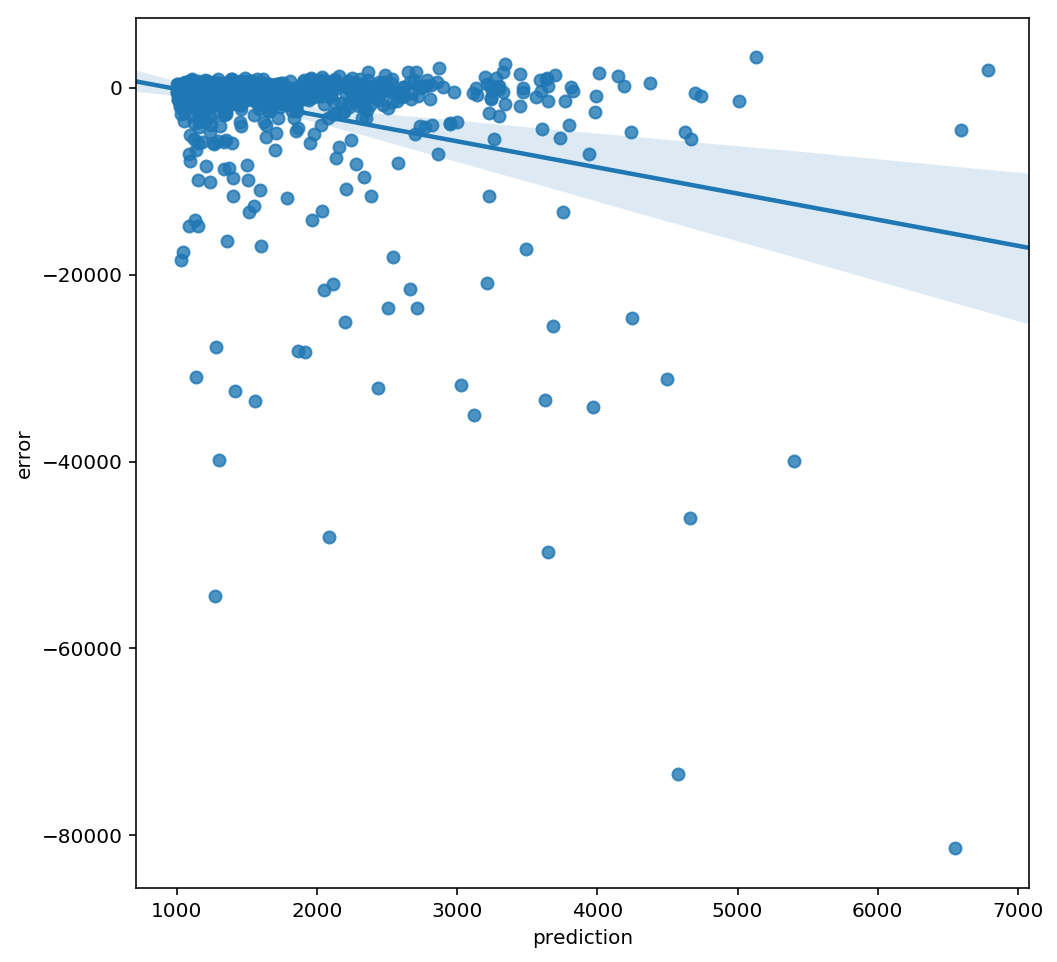

In [226]:
fig = plt.figure(figsize=(8,8));
ax = fig.add_subplot(1, 1, 1)
data = df_preds[(df_preds["prediction"]>=1000)&(df_preds["prediction"]<=20000)]
sns.regplot(x='prediction',y='error',data=data.sample(1000),ax=ax)

(1000.0, 9276.310546875)


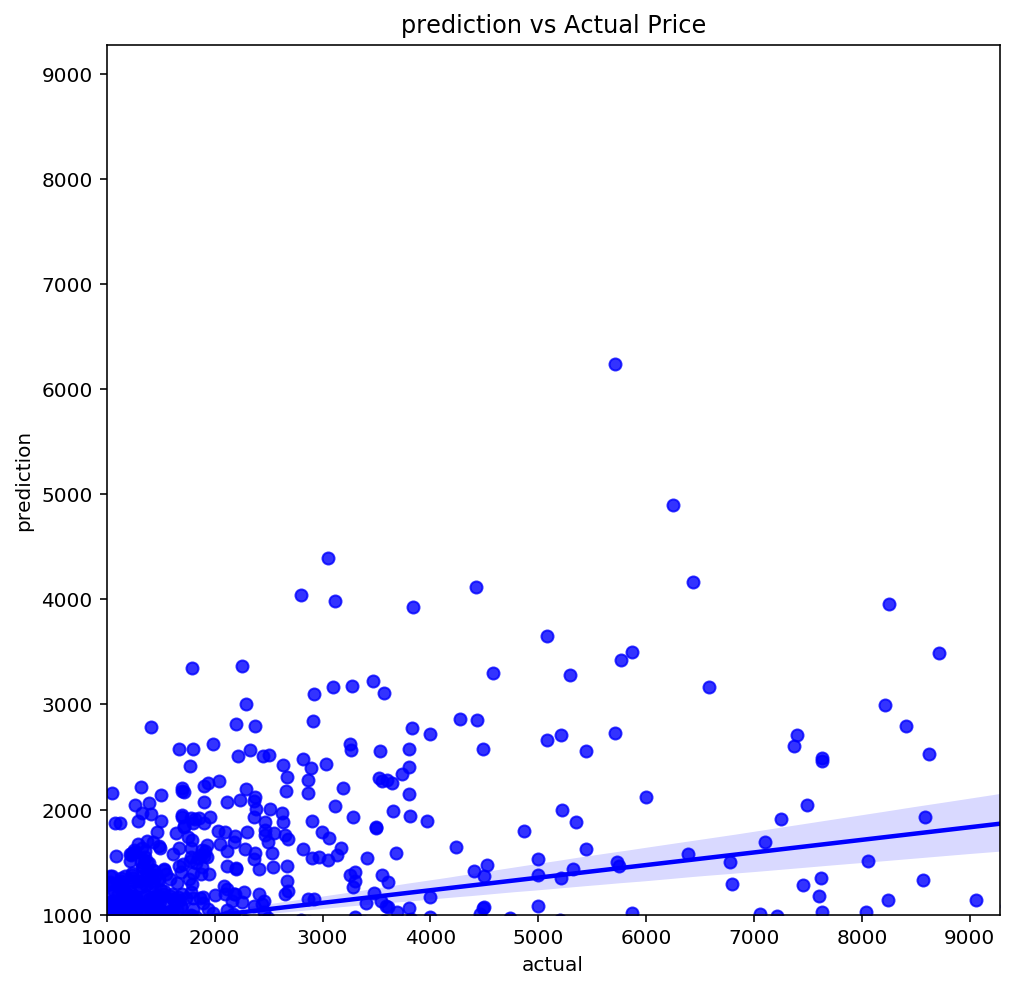

In [257]:
def actual_vs_other_column(column,actual_range):

    fig = plt.figure(figsize=(8,8));
    ax = fig.add_subplot(1, 1, 1)
    ax.set_title("%s vs Actual Price"%(column))
    rng = actual_range
    data = df_preds[(df_preds["actual"]>=rng[0])&(df_preds["actual"]<=rng[1])]
    plot_range = (data[['actual',column]].min().max(),data[['actual',column]].max().min())
    print(plot_range)
    sns.regplot(x="actual", y=column, data=data.sample(1000), color="b", ax = ax,fit_reg=True);
    plt.xlim(plot_range)
    plt.ylim(plot_range)
    plt.show()
actual_vs_other_column('prediction',(1000,10000))

In [251]:
df_preds.groupby(["GL"])[["actual","prediction"]].agg(['mean'])

,actual,prediction
,mean,mean
GL,,
gl_apparel,768.029893,589.132507
gl_art,3348.213333,705.907410
gl_arts_collectibles,1850.000000,697.336304
gl_audible,734.428571,463.116425
gl_automotive,1164.599182,570.830200
gl_baby_product,1135.208436,441.768616
gl_beauty,1352.917742,519.365234
gl_biss,1912.402227,465.544586


# Observations and Suggestion for Improvements

## Observations

- Finding Good Learning rate was important
- Combining Pretrained embeddings with Trained Embeddings helped.
- Resnet Architecture Skip Connections boost performance (Vanishing Gradients).
- Model Trained Embeddings did better than Pretrained Embeddings (Data size may be a reason)
- Going Wide Helped (128 vs 256)
- Saving Intermediate preprocessing steps helped in gaining speed.
- P3.8x Large Sagemaker Instance has multi-gpu (8 total), this needs separate Tensorflow sessions, I used separate notebooks
- Normalizing word vectors for Pretrained model was lowering performance, word vector lengths matter when you consider Text classification tasks, for NLP tasks like similarity they don't since cosine distance is used.
- The Process of using Word CNNs is easily carried over to Sub-categories Classification
- Why Ensembling Did not work?
    - Models with dropouts are like ensembles themselves
    - Only significant architecture or preprocessing step difference will help
- Why Char CNN did not work?
    - Long training time and huge number of computations
- Following a structured process was important
    - You might think something will improve the results but trying things without reasoning usually gives sub-par results

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


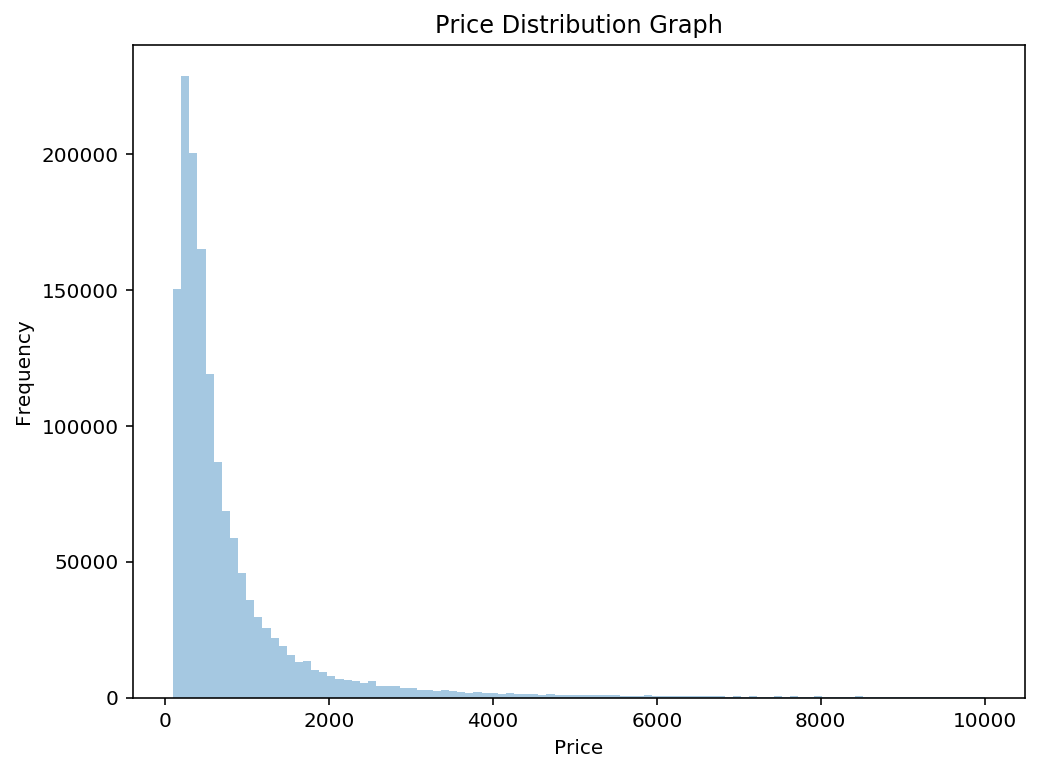

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


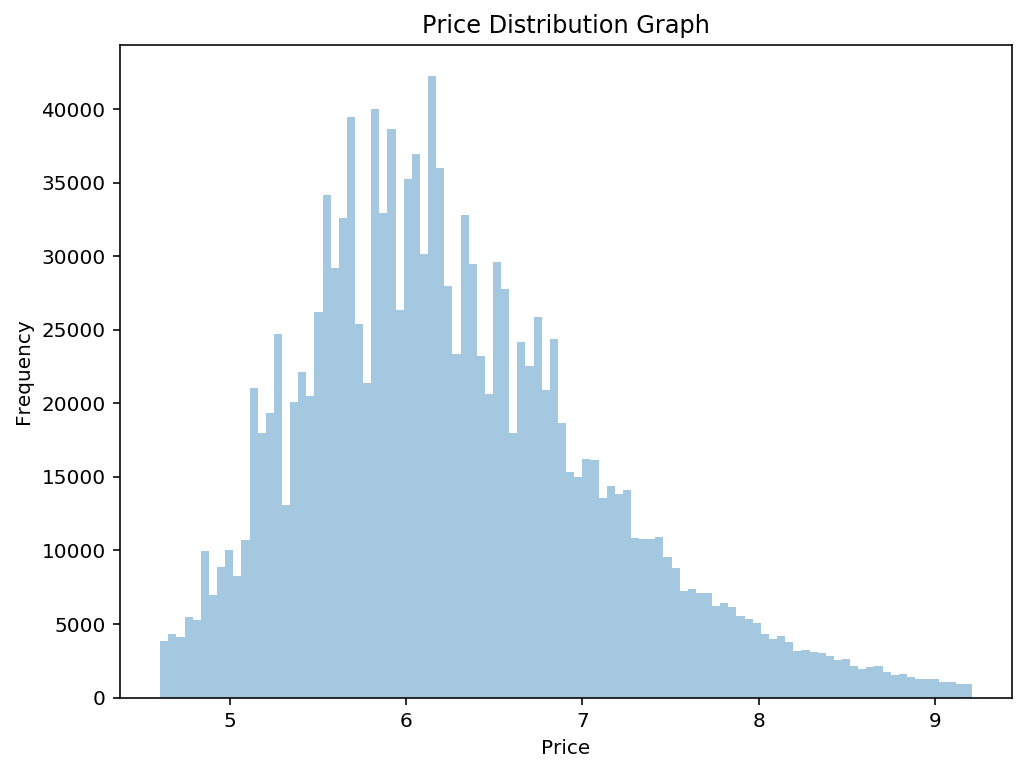

In [45]:
# Target Distribution Histogram

# Target Distribution Histogram
_ = plt.figure(figsize=(8,6));
_ = sns.distplot(df_train[df_train['PRICE']<1e4]['PRICE'].astype(float).values,bins=100,kde=False);
_ = plt.xlabel("Price");
_ = plt.ylabel("Frequency");
_ = plt.title("Price Distribution Graph");
# _ = plt.semilogy();
_ = plt.show();

_ = plt.figure(figsize=(8,6));
_ = sns.distplot(np.log(df_train[df_train['PRICE']<1e4]['PRICE'].astype(float).values),bins=100,kde=False);
_ = plt.xlabel("Price");
_ = plt.ylabel("Frequency");
_ = plt.title("Price Distribution Graph");
# _ = plt.semilogy();
_ = plt.show();

## Improvements

- **Improving Word Embeddings**
    - Pretrained Fasttext or Bert/Elmo Models for text representation.
    - Instead of using Both Pretrained and Trained embeddings, Initializing Embedding layer with Pretrained vectors
        - Helpful for representing low frequency words.
        - This will help us by not filtering low vocab words before training.
    - Trying POS tags with lemmatized words
- **Target Variable**
    - Training with Log/CubeRoot/Standard Scaling of target since target is skewed.
    - Bucketing/Quantizing: Dividing prices into cube-rooted buckets and then feeding the top 10 bucket prediction to final model.
- **Training Improvements**
    - LR scheduling, Cyclic LR and Super Convergence
    - More Epochs
- **Other Suggestions**
    - Inspecting Errors and finding text patterns we missed
    - GL specific Models (avoid global mean bias)

## References

# Appendix

## Competition Architecture

In [304]:
# set parameters:
max_features = 50000
maxlen = 100
batch_size = 256
embedding_dims = 50
filters = 256
kernel_size = 3
hidden_dims = 256
epochs = 2

X,X_gl,y = df_train['text_encoded'].values,df_train['GL_encoded'].values,df_train['PRICE'].values
X_gl = X_gl.reshape((-1,1))
x_train, x_test,x_gl_train,x_gl_test, y_train, y_test = train_test_split(X,X_gl, y, test_size=0.2, random_state=42)

x_train = sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = sequence.pad_sequences(x_test, maxlen=maxlen)


main_input = Input(shape=(maxlen,), dtype='int32', name='main_input')
embedding = Embedding(max_features,
                    embedding_dims,
                    input_length=maxlen)(main_input)
x = Dropout(0.2)(embedding)

# we add a Convolution1D, which will learn filters
# word group filters of size filter_length:


vlayer = conv_layer(embedding,n_kernels=48,kernel_size=5,padding='valid')
vlayer_out = SpatialDropout1D(0.1)(vlayer)
vlayer_out = GlobalAveragePooling1D()(vlayer_out)

x = Conv1D(filters,
                 kernel_size,
                 padding='valid',
                 activation='relu',
                 strides=1)(x)
# we use max pooling:
x = GlobalMaxPooling1D()(x)

x = concatenate([vlayer_out,x])
auxiliary_input =  Input(shape=(1,), dtype='int32', name='aux_input')
aux = Embedding(len(gl_le.classes_),
                    8,
                    input_length=1)(auxiliary_input)
aux = Flatten()(aux)
x = concatenate([x,aux])

# We add a vanilla hidden layer:
x = Dense(hidden_dims)(x)
x = Dropout(0.2)(x)
x = Activation('relu')(x)

# We project onto a single unit output layer, and squash it with a sigmoid:
main_output = Dense(1)(x)

model = Model(inputs=[main_input, auxiliary_input], outputs=[main_output])
visualizer = Model(inputs=[main_input], outputs=vlayer)
embedder = Model(inputs=[main_input], outputs=embedding)

model.compile(loss='mean_squared_error',
              optimizer='adam',
              metrics=['mean_squared_error',mape_error])


print("Param count = ", model.count_params())

Param count =  2631777


In [305]:
# Competition Architecture
# ======== Using MSE as the Error Fn ==========
# MSE = 14706004.62, MAPE = 77.08, MEDAPE = 48.70
# MSE = 14646295.58, MAPE = 84.37, MEDAPE = 44.54
# MSE = 14438024.00, MAPE = 88.92, MEDAPE = 46.23

# ======= Using MAPE as the Error Fn ==========
# MSE = 19208402.34, MAPE = 35.03, MEDAPE = 27.54
# MSE = 19170641.31, MAPE = 34.86, MEDAPE = 27.29

<module 'keras.utils.vis_utils' from '/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/utils/vis_utils.py'>

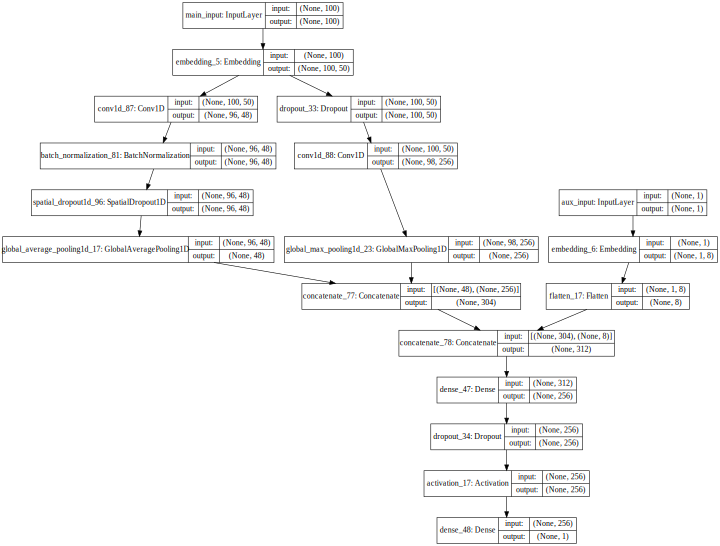

In [306]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
reload(keras.utils.vis_utils)
m2d = model_to_dot(model, show_shapes=True,)
m2d.set_size('10x20')
SVG(m2d.create(prog='dot', format='svg'))

In [307]:
from keras.utils import plot_model
plot_model(model, to_file='model-old.png')

# Asin Classification into Sub-Categories